# Introduction

## Understanding Time Series Forecasting

Time series forecasting is a crucial field in data science. It involves analyzing historical data points and making predictions for the future. It has significant importance across various industries, helping with resource allocation, decision-making, customer satisfaction, and financial planning.

## Importance of Time Series Forecasting

Time series data consists of data points recorded at successive time intervals. The ability to forecast future data points within these series is essential for:

- **Efficient Resource Allocation:** Companies can allocate resources effectively based on future predictions.

- **Informed Decision-Making:** Time series forecasting provides insights for data-driven decisions that align with future trends.

- **Improved Customer Satisfaction**: Accurate demand forecasting, as seen in retail, enhances customer experiences.

- **Financial Planning**: In finance, forecasting stock prices, currency rates, or bond yields is critical for investment strategies.

In this project, we'll explore time series forecasting using Python, Pandas, Numpy, Matplotlib, Seaborn, and the statsmodels library. Our aim is to provide clear insights for businesses and organizations.
## Rossmann Store Sales Dataset

Rossmann is a renowned European drugstore chain with a vast network of stores in multiple countries, including Germany, Poland, and others. The Rossmann Group specializes in the retail of various products, encompassing pharmaceuticals, health and beauty items, household essentials, and more.

The "Rossmann Store Sales" dataset is a valuable resource in the domain of data science and machine learning. It provides historical sales data for the Rossmann drugstore chain, a prominent retail organization with a significant presence across Europe.

The dataset consists of essential information about Rossmann stores, promotions, holidays, and sales. Here are key details:

- **Store Data:** Information about each Rossmann store, including its unique identifier, type, assortment, competition, and more.

- **Sales Data:** Weekly sales figures for each store.

- **Promotion Data:** Details about promotions, including start and end dates and additional details.

- **Holiday Data:** Information about holidays that might affect store sales.

The primary objective of using this dataset is to predict and analyze store sales based on various factors, including promotions, holidays, and store-specific attributes. It serves as an invaluable resource for data scientists and analysts working on time series forecasting and retail sales prediction tasks.

This dataset is widely used in the data science community for building predictive models and deriving insights to optimize store operations and enhance decision-making within the retail industry.

# Importing Packages

In [1]:
import os
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels as sm
from pmdarima.arima import auto_arima
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import acf, adfuller, kpss, pacf

warnings.filterwarnings("ignore")

## Data Fields

Most of the fields are self-explanatory. The following are descriptions for those that aren't.

| Field                        | Description                                                                                     |
|------------------------------|-------------------------------------------------------------------------------------------------|
| Id                           | An identifier representing a (Store, Date) pair within the test set.                            |
| Store                        | A unique ID for each Rossmann store.                                                           |
| Sales                        | The turnover for any given day, which is the target variable for prediction.                   |
| Customers                    | The number of customers visiting the store on a given day.                                     |
| Open                         | An indicator for whether the store was open on a particular day: 0 for closed, 1 for open.     |
| StateHoliday                 | Indicates a state holiday. Normally, most stores are closed on state holidays. "a" denotes a public holiday, "b" represents Easter holiday, "c" corresponds to Christmas and "0" indicates no state holiday.|
| SchoolHoliday                | Indicates whether the (Store, Date) was affected by the closure of public schools.            |
| StoreType                    | Differentiates between four store models: "a," "b," "c," and "d."                                |
| Assortment                   | Describes the assortment level of the store: "a" represents basic assortment, "b" indicates extra assortment and "c" stands for extended assortment.|
| CompetitionDistance          | The distance in meters to the nearest competitor store.                                        |
| CompetitionOpenSince[Month/Year] | Gives the approximate year and month when the nearest competitor store was opened.     |
| Promo                        | Indicates whether a store is running a promotional campaign on a particular day.              |
| Promo2                       | Promo2 is a continuing and consecutive promotion for some stores: "0" means the store is not participating in Promo2 and "0" means the store is not participating in Promo2. |
| Promo2Since[Year/Week]       | Describes the year and calendar week when the store started participating in Promo2.            |
| PromoInterval                | Describes the consecutive intervals when Promo2 is initiated, naming the months of each start. Example: "Feb,May,Aug,Nov" means Promo2 starts in February, May, August, and November each year for that store.|


# Data Collection

I'll use Kaggle to get access to the dataset, but feel free to use any tool you like.

In [2]:
if not any((
    os.path.isfile(f"data/{f}.csv")
    for f in ("train", "test", "store")
)):
    !kaggle competitions download -c rossmann-store-sales -p data
    !unzip data/rossmann-store-sales.zip -d data
    !rm data/rossmann-store-sales.zip
else:
    print("Datal already exists!")

Datal already exists!


## store.csv

This file provides additional information about each Rossmann store, such as the store type ("StoreType"), assortment level ("Assortment"), competition distance ("CompetitionDistance"), and details about when the nearest competitor store opened ("CompetitionOpenSince[Month/Year]").

### Load the Store Information Data

In [3]:
stores_df = pd.read_csv("data/store.csv")
stores_df

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
1110,1111,a,a,1900.0,6.0,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct"
1111,1112,c,c,1880.0,4.0,2006.0,0,NaN,NaN,NaN
1112,1113,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN
1113,1114,a,c,870.0,NaN,NaN,0,NaN,NaN,NaN


Much of this data is self-explanatory. **CompetitionOpenSinceMonth** and **CompetitionOpenSinceYear** are dependent of each other, and there are some missing values in them but, given that are valid **CompetitionDistance** values for these missing values, they may indicate uncertainty about when the nearest competitor opened instead of absence of competition.

**Promo2SinceWeek**, **Promo2SinceYear** and **PromoInterval** are all dependent of **Promo2**, as if it's value is 0, then the corresponding values of the other columns will be missing, which makes sense.

### Understand the Store Information Data

In [4]:
stores_df.shape

(1115, 10)

This data contains 10 feature fields about 1115 stores.

In [5]:
stores_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType                  1115 non-null   object 
 2   Assortment                 1115 non-null   object 
 3   CompetitionDistance        1112 non-null   float64
 4   CompetitionOpenSinceMonth  761 non-null    float64
 5   CompetitionOpenSinceYear   761 non-null    float64
 6   Promo2                     1115 non-null   int64  
 7   Promo2SinceWeek            571 non-null    float64
 8   Promo2SinceYear            571 non-null    float64
 9   PromoInterval              571 non-null    object 
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


StoreType, Assortment and PromoInterval are string features. All others are numerical.

### Summary Information Statistics

Let's check the numerical features statistics first.

In [6]:
stores_df.describe()

,Store,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear
count,1115.00000,1112.000000,761.000000,761.000000,1115.000000,571.000000,571.000000
mean,558.00000,5404.901079,7.224704,2008.668857,0.512108,23.595447,2011.763573
std,322.01708,7663.174720,3.212348,6.195983,0.500078,14.141984,1.674935
min,1.00000,20.000000,1.000000,1900.000000,0.000000,1.000000,2009.000000
25%,279.50000,717.500000,4.000000,2006.000000,0.000000,13.000000,2011.000000
50%,558.00000,2325.000000,8.000000,2010.000000,1.000000,22.000000,2012.000000
75%,836.50000,6882.500000,10.000000,2013.000000,1.000000,37.000000,2013.000000
max,1115.00000,75860.000000,12.000000,2015.000000,1.000000,50.000000,2015.000000


- **Store** is just the unique IDs assigned for each store, so it's statistics doesn't bring us any valueble information.
- **Promo2** has only 2 unique values, so this feature is **binary**.
- **CompetitionOpenSinceYear** and **CompetitionOpenSinceMonth** only make sense when combined.
- The same thing happens with **Promo2SinceWeek** and **Promo2SinceYear**.
- **CompetitionOpenSinceYear** has a wide gap between it's minimum value and first quartile. It would be logical to think of year **1900** as an **unknown** value.

Now we'll proceed to the string features.

In [7]:
stores_df.describe(include="O")

,StoreType,Assortment,PromoInterval
count,1115,1115,571
unique,4,3,3
top,a,a,"Jan,Apr,Jul,Oct"
freq,602,593,335


- All of these features have low cardinality, so we can safelly consider them as **categorica features**.
- Almost 50% of **PromoInterval** values are missing.
- We can already see that the top most frequent values of each of these features represents almost 50% of the data.

### Data Visualization

Now we'll begin the visual analysis, starting with categorical features.

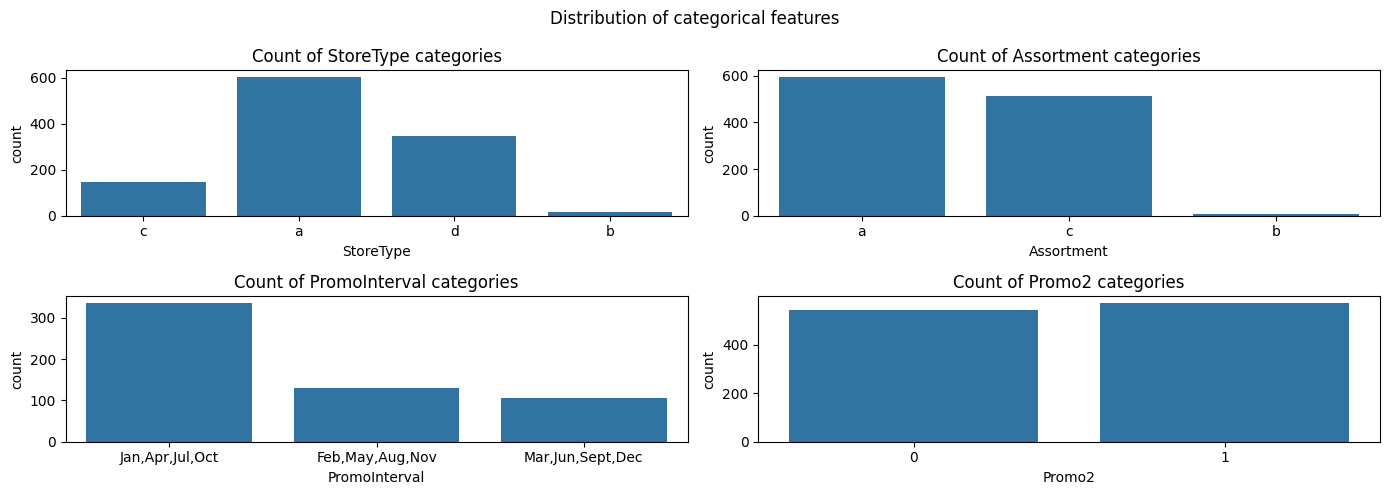

In [8]:
stores_category_fields = (
    "StoreType",
    "Assortment",
    "PromoInterval",
    "Promo2"
)

fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(14, 5))

axs = [ax for sub in axs for ax in sub]

for ax, col in zip(axs, stores_category_fields):
    sns.countplot(data=stores_df, x=col, ax=ax)
    ax.set_title(f"Count of {col} categories")

fig.suptitle("Distribution of categorical features")
plt.tight_layout()
plt.show()

For **StoreType**:
- **a** and **d** are the most common store types, with **a** being the most prevalent.
- Type **b** is the least common, significantly outnumbered by **c**.

For **Assortments**:
- **a** and **c** assortments dominate, with **a** having the highest frequency.
- **b** assortments are infrequent.

For **PromoInterval**:
- Three promotion cycles exist, each one month apart.
- `Jan, Apr, Jul, Oct` is the most prevalent, representing over half of the data.

For **Promo2**:
- About half of the stores participate in consecutive promotions (Promo2).
For **CompetitionDistance**:
- Data exhibits positive skewness with potential outliers.
- Most competition distances range from 0 to 15,000 meters.
- Median distance is 2,325 meters.

For **CompetitionOpenSinceMonth** and **CompetitionOpenSinceYear**:
- Most competitors opened in the mid-2010s.
- Peak years for competition openings were 2006 to 2013.
- "1900" seems to indicate missing/opening year data.

For **Promo2SinceWeek** and **Promo2SinceYear**:
- Promo2 adoption occurred between 2009 and 2015.
- 2011 and 2013 had the highest adoption rates for Promo2.

Now let's check the continuous features.

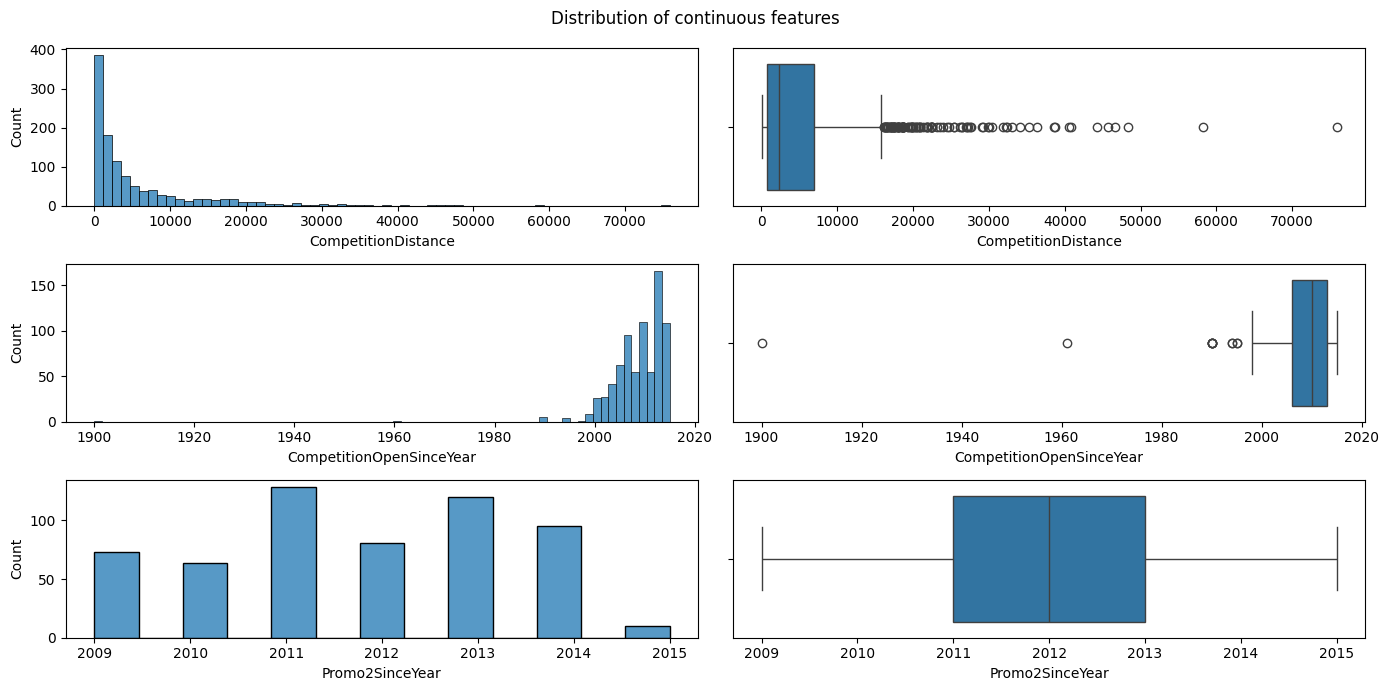

In [9]:
stores_numerical_fields = (
    "CompetitionDistance",
    "CompetitionOpenSinceYear",
    "Promo2SinceYear",
)

fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(14, 7))

for (ax1, ax2), col in zip(axs, stores_numerical_fields):
    sns.histplot(data=stores_df, x=col, ax=ax1)
    sns.boxplot(data=stores_df, x=col, ax=ax2)
    ax.set_title(f"Values distribution of {col} categories")

fig.suptitle("Distribution of continuous features")
plt.tight_layout()
plt.show()

- **CompetitionDistance** is highly positive skewed, with a great concentration of values around 0.
- **CompetitionOpenSinceYear** plot is showing that most of the competion is, indeed, pretty recent.
- **Promo2SinceYear** show that the adoption of promo2 started in 2009. Since then, each year has the same level of adoption, with 2011 and 2013 being the years with most adoptions.

### Missing Values

In [10]:
stores_df.isna().sum()

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

- The missing values in **CompetitionDistance**, **CompetitionOpenSinceMonth** and **CompetitionOpenSinceYear** may indicate that there isn't a tracked competition in the nearby store.
- The missing values in **Promo2SinceWeek**, **Promo2SinceYear** and **PromoInterval** may be related to stores that don't adopt the consecutive promotion.

## train.csv

This file contains historical sales data and various attributes related to Rossmann stores, including "Store," "Date," "Sales," "Customers," "Open," and other relevant features. It is used for training machine learning models.

### Load the Sales Data

In [11]:
sales_df = pd.read_csv("data/train.csv")
sales_df["Date"] = pd.to_datetime(sales_df["Date"])
sales_df

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1
...,...,...,...,...,...,...,...,...,...
1017204,1111,2,2013-01-01,0,0,0,0,a,1
1017205,1112,2,2013-01-01,0,0,0,0,a,1
1017206,1113,2,2013-01-01,0,0,0,0,a,1
1017207,1114,2,2013-01-01,0,0,0,0,a,1


Again, much of these features are self-explanatory. Each entry represents sales data and conditions of a specific store in a specific date. We can expect that **Sales**, **Customers** and **Open** features to be highly related. 

### Understand the Sales Data

In [12]:
sales_df.shape

(1017209, 9)

We have 9 features for 1017209 entries

In [13]:
sales_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype         
---  ------         --------------    -----         
 0   Store          1017209 non-null  int64         
 1   DayOfWeek      1017209 non-null  int64         
 2   Date           1017209 non-null  datetime64[ns]
 3   Sales          1017209 non-null  int64         
 4   Customers      1017209 non-null  int64         
 5   Open           1017209 non-null  int64         
 6   Promo          1017209 non-null  int64         
 7   StateHoliday   1017209 non-null  object        
 8   SchoolHoliday  1017209 non-null  int64         
dtypes: datetime64[ns](1), int64(7), object(1)
memory usage: 69.8+ MB


Almost all features are represented by integers, except by **Date** (**datetime** types) and **StateHoliday** (**string** values).

**StoreId** is just the unique IDs for each store (mapped to **StoreId** in **stores.csv**).

This data is also complete, without missing values.

### Summary Statistics

In [14]:
sales_df.describe()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,SchoolHoliday
count,1.017209e+06,1.017209e+06,1017209,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06
mean,5.584297e+02,3.998341e+00,2014-04-11 01:30:42.846061824,5.773819e+03,6.331459e+02,8.301067e-01,3.815145e-01,1.786467e-01
min,1.000000e+00,1.000000e+00,2013-01-01 00:00:00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.800000e+02,2.000000e+00,2013-08-17 00:00:00,3.727000e+03,4.050000e+02,1.000000e+00,0.000000e+00,0.000000e+00
50%,5.580000e+02,4.000000e+00,2014-04-02 00:00:00,5.744000e+03,6.090000e+02,1.000000e+00,0.000000e+00,0.000000e+00
75%,8.380000e+02,6.000000e+00,2014-12-12 00:00:00,7.856000e+03,8.370000e+02,1.000000e+00,1.000000e+00,0.000000e+00
max,1.115000e+03,7.000000e+00,2015-07-31 00:00:00,4.155100e+04,7.388000e+03,1.000000e+00,1.000000e+00,1.000000e+00
std,3.219087e+02,1.997391e+00,NaN,3.849926e+03,4.644117e+02,3.755392e-01,4.857586e-01,3.830564e-01


- Features **DayOfWeek** and **Date** don't mean much other than the historical data of each features.
- 50% of the sales data is in between [3727 - 7856]. The high variation to the max value of 41551 may indicate the presence of outliers.
- 50% of the customers numbers data is in between [405 - 837]. The high variation to the max value of 7.388 may indicate the presence of outliers.
- **Open**, **Promo** and **SchoolHoliday** are **binary** features.

In [15]:
sales_df.describe(include="O")

,StateHoliday
count,1017209
unique,5
top,0
freq,855087


- **SateHoliday** has only 5 unique features, so we can safetly consider it a **categorical** feature.

### Data Visualization

All this data won't bring any insight if we don't see their evolution throught time. So we'll begin by creating features related to the days of the week and periods in time.

In [16]:
# First, we'll recreate the day of week number by using Pandas's standard.
sales_df["DayOfWeek"] = sales_df["Date"].dt.weekday

sales_df["DayOfMonth"] = sales_df["Date"].dt.day
sales_df["Week"] = sales_df["Date"].dt.isocalendar().week
sales_df["Month"] = sales_df["Date"].dt.month
sales_df["Year"] = sales_df["Date"].dt.year

sales_df

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,DayOfMonth,Week,Month,Year
0,1,4,2015-07-31,5263,555,1,1,0,1,31,31,7,2015
1,2,4,2015-07-31,6064,625,1,1,0,1,31,31,7,2015
2,3,4,2015-07-31,8314,821,1,1,0,1,31,31,7,2015
3,4,4,2015-07-31,13995,1498,1,1,0,1,31,31,7,2015
4,5,4,2015-07-31,4822,559,1,1,0,1,31,31,7,2015
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017204,1111,1,2013-01-01,0,0,0,0,a,1,1,1,1,2013
1017205,1112,1,2013-01-01,0,0,0,0,a,1,1,1,1,2013
1017206,1113,1,2013-01-01,0,0,0,0,a,1,1,1,1,2013
1017207,1114,1,2013-01-01,0,0,0,0,a,1,1,1,1,2013


Now we'll check how promotions are distributed through time.

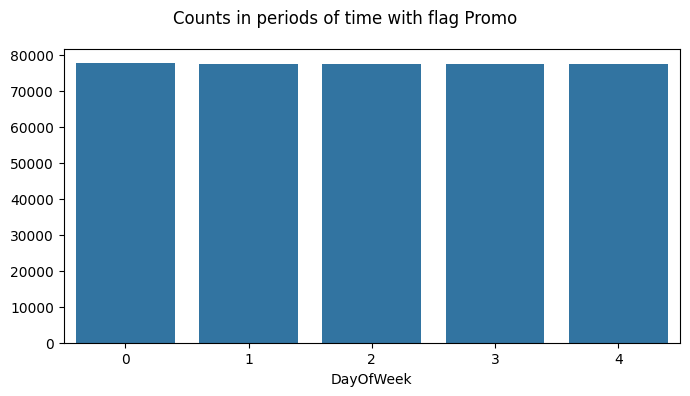

In [17]:
fig = plt.figure(figsize=(7, 4))

sns.countplot(data=sales_df[sales_df["Promo"] == 1], x="DayOfWeek")
plt.ylabel("")

fig.suptitle(f"Counts in periods of time with flag Promo")

plt.tight_layout()
plt.show()

- We can see a period pattern in the distribution of promotion by days of month, with a concentration in in 4th, 18th and last days of the month.
- We can also see that promotions occur more in the beginning of the first the week of the year (maybe **clearance sales** following christmas), early february to mid-march (**summer sale**) and beginning of june till August (**winter sale**).
- Weeks 1, 7, 11, 24, 26, 28, 30, 42, 44 and 50 don't have any promotion days.
- Finally, there aren't promotions in saturdays and mondays, and it makes sense, as customers go to stores more in work days and retailers want to maximizer their profits.

Next we'll check how much stores open for each week day.

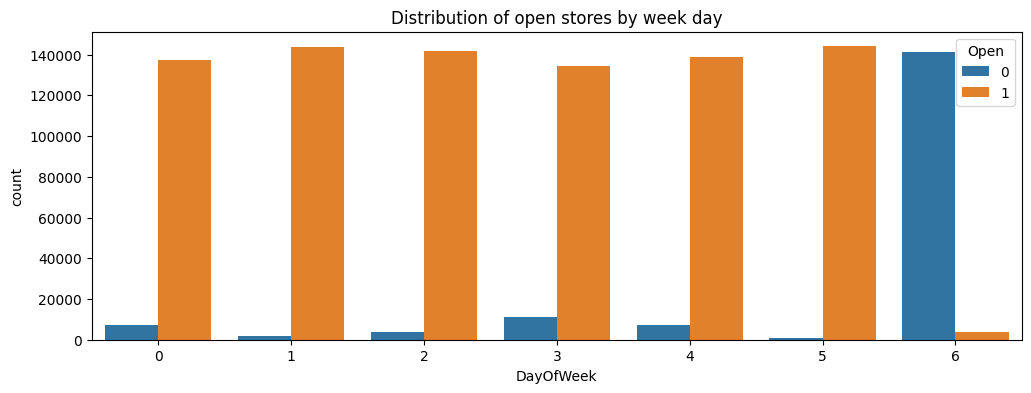

In [18]:
plt.figure(figsize=(12, 4))
sns.countplot(data=sales_df, x="DayOfWeek", hue="Open")
plt.title("Distribution of open stores by week day");

- Generally speaking, stores don't open on sundays.

Now we'll check how much stores stores are open by holiday type.

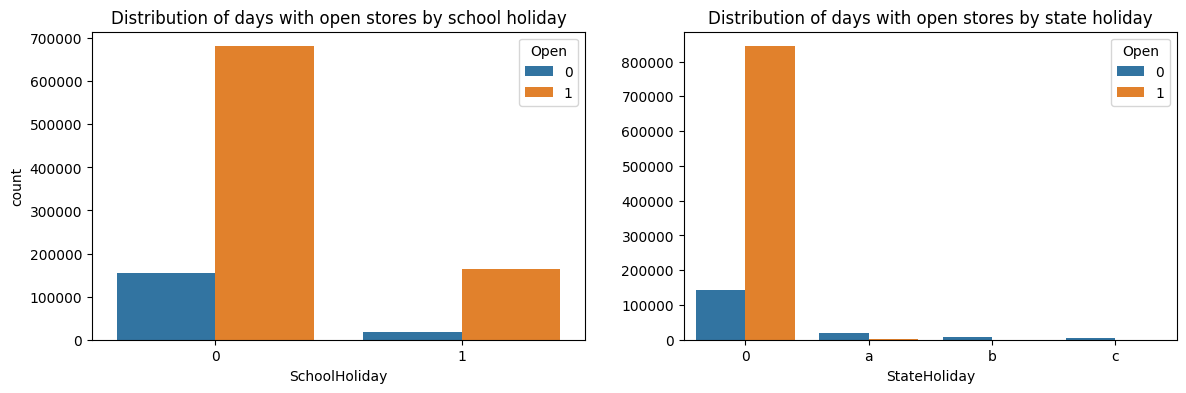

In [19]:
_, (ax1, ax2) = plt.subplots(ncols=2, figsize=(14, 4))

sns.countplot(data=sales_df, x="SchoolHoliday", hue="Open", ax=ax1)
ax1.set_title("Distribution of days with open stores by school holiday")

sns.countplot(data=sales_df, x="StateHoliday", hue="Open", ax=ax2)
ax2.set_title("Distribution of days with open stores by state holiday")
ax2.set_ylabel("");

- Stores generally open ate school holidays.
- Stores generally don't open in state holidays.
- For non holidays, there is a certain amount of days where stores don't open for other reasons.

Now we'll take a look at our most important features: **Sales** and **Customers**

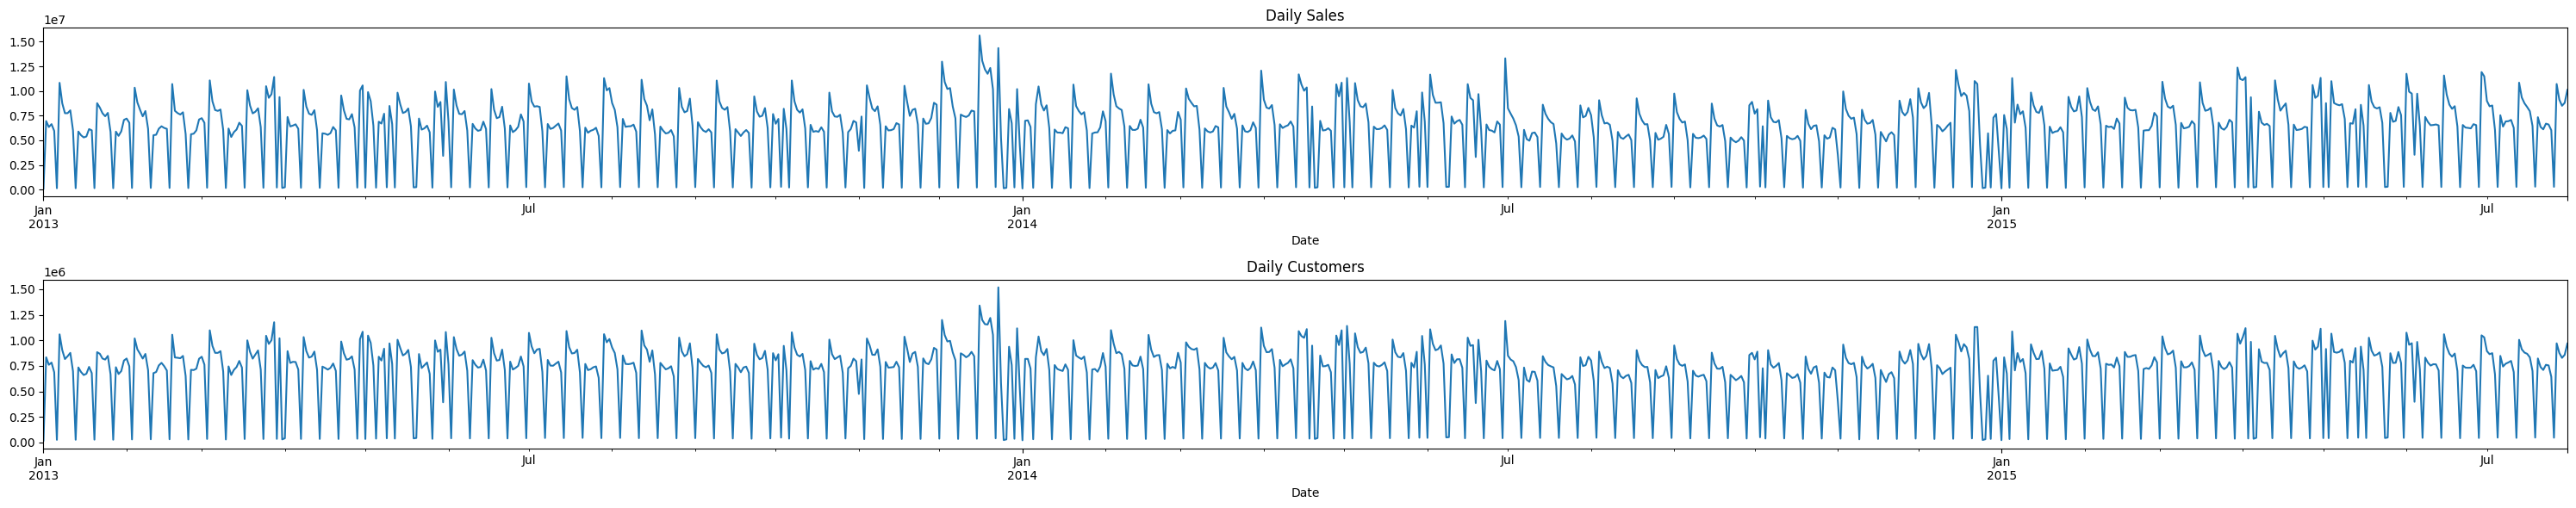

In [20]:
total_sales_opened_df = sales_df.groupby("Date")[["Sales", "Customers"]].sum()

fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(30, 6))

total_sales_opened_df["Sales"].plot(kind="line", ax=ax1)
ax1.set_title("Daily Sales");

total_sales_opened_df["Customers"].plot(kind="line", ax=ax2)
ax2.set_title("Daily Customers")

plt.tight_layout()
plt.show();

We can see some kind of periodic pattern shared by both features, indicating a high correlation between them.

## Multi variate analysis

Multivariate analysis goes beyond examining individual attributes and allows us to uncover complex relationships, patterns, and dependencies among various factors.

Through a systematic examination of how different variables interact, we aim to gain a deeper understanding of the dynamics that influence sales, customer behavior, and store performance. By leveraging the power of multivariate analysis techniques, we can extract valuable insights and build predictive models that offer a more comprehensive perspective on the retail landscape.

In the following segments, we will explore techniques such as correlation analysis, multiple variable visualizations, and advanced statistical modeling. These methods will enable us to identify key drivers of sales, uncover hidden trends, and ultimately enhance our ability to make data-informed decisions.

### Joining the datasets

Joining the **stores** and **sales** data will enables us to answer questions that require a deep understanding of the this problem. How do store characteristics influence sales? What role do promotions and state holidays play in store performance? How can we harness this integrated dataset to build accurate predictive models for sales forecasting?

In [21]:
stores_sales_df = sales_df.merge(stores_df, on="Store").set_index("Date", drop=True)
stores_sales_df

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,DayOfMonth,Week,...,Year,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
Date,,,,,,,,,,,,,,,,,,,,,
2015-07-31,1,4,5263,555,1,1,0,1,31,31,...,2015,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
2015-07-30,1,3,5020,546,1,1,0,1,30,31,...,2015,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
2015-07-29,1,2,4782,523,1,1,0,1,29,31,...,2015,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
2015-07-28,1,1,5011,560,1,1,0,1,28,31,...,2015,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
2015-07-27,1,0,6102,612,1,1,0,1,27,31,...,2015,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-01-05,1115,5,4771,339,1,0,0,1,5,1,...,2013,d,c,5350.0,NaN,NaN,1,22.0,2012.0,"Mar,Jun,Sept,Dec"
2013-01-04,1115,4,4540,326,1,0,0,1,4,1,...,2013,d,c,5350.0,NaN,NaN,1,22.0,2012.0,"Mar,Jun,Sept,Dec"
2013-01-03,1115,3,4297,300,1,0,0,1,3,1,...,2013,d,c,5350.0,NaN,NaN,1,22.0,2012.0,"Mar,Jun,Sept,Dec"


### Correlation matrix

The correlation matrix will assists us in quantifying, identifying, and understanding relationships between variables, leading to useful data-driven insights, setting the stage for more advanced analyses and predictive modeling.

First of all, the correlation matrix can be computed with numerical features only. So, we'll have to transform categorical features' string values to numbers.

In [22]:
stores_sales_copy = stores_sales_df.copy()

for col in stores_sales_copy.columns:
    if pd.api.types.is_object_dtype(stores_sales_copy[col]):
        stores_sales_copy[col] = pd.Categorical(stores_sales_copy[col]).codes

stores_sales_copy

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,DayOfMonth,Week,...,Year,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
Date,,,,,,,,,,,,,,,,,,,,,
2015-07-31,1,4,5263,555,1,1,1,1,31,31,...,2015,2,0,1270.0,9.0,2008.0,0,NaN,NaN,-1
2015-07-30,1,3,5020,546,1,1,1,1,30,31,...,2015,2,0,1270.0,9.0,2008.0,0,NaN,NaN,-1
2015-07-29,1,2,4782,523,1,1,1,1,29,31,...,2015,2,0,1270.0,9.0,2008.0,0,NaN,NaN,-1
2015-07-28,1,1,5011,560,1,1,1,1,28,31,...,2015,2,0,1270.0,9.0,2008.0,0,NaN,NaN,-1
2015-07-27,1,0,6102,612,1,1,1,1,27,31,...,2015,2,0,1270.0,9.0,2008.0,0,NaN,NaN,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-01-05,1115,5,4771,339,1,0,1,1,5,1,...,2013,3,2,5350.0,NaN,NaN,1,22.0,2012.0,2
2013-01-04,1115,4,4540,326,1,0,1,1,4,1,...,2013,3,2,5350.0,NaN,NaN,1,22.0,2012.0,2
2013-01-03,1115,3,4297,300,1,0,1,1,3,1,...,2013,3,2,5350.0,NaN,NaN,1,22.0,2012.0,2


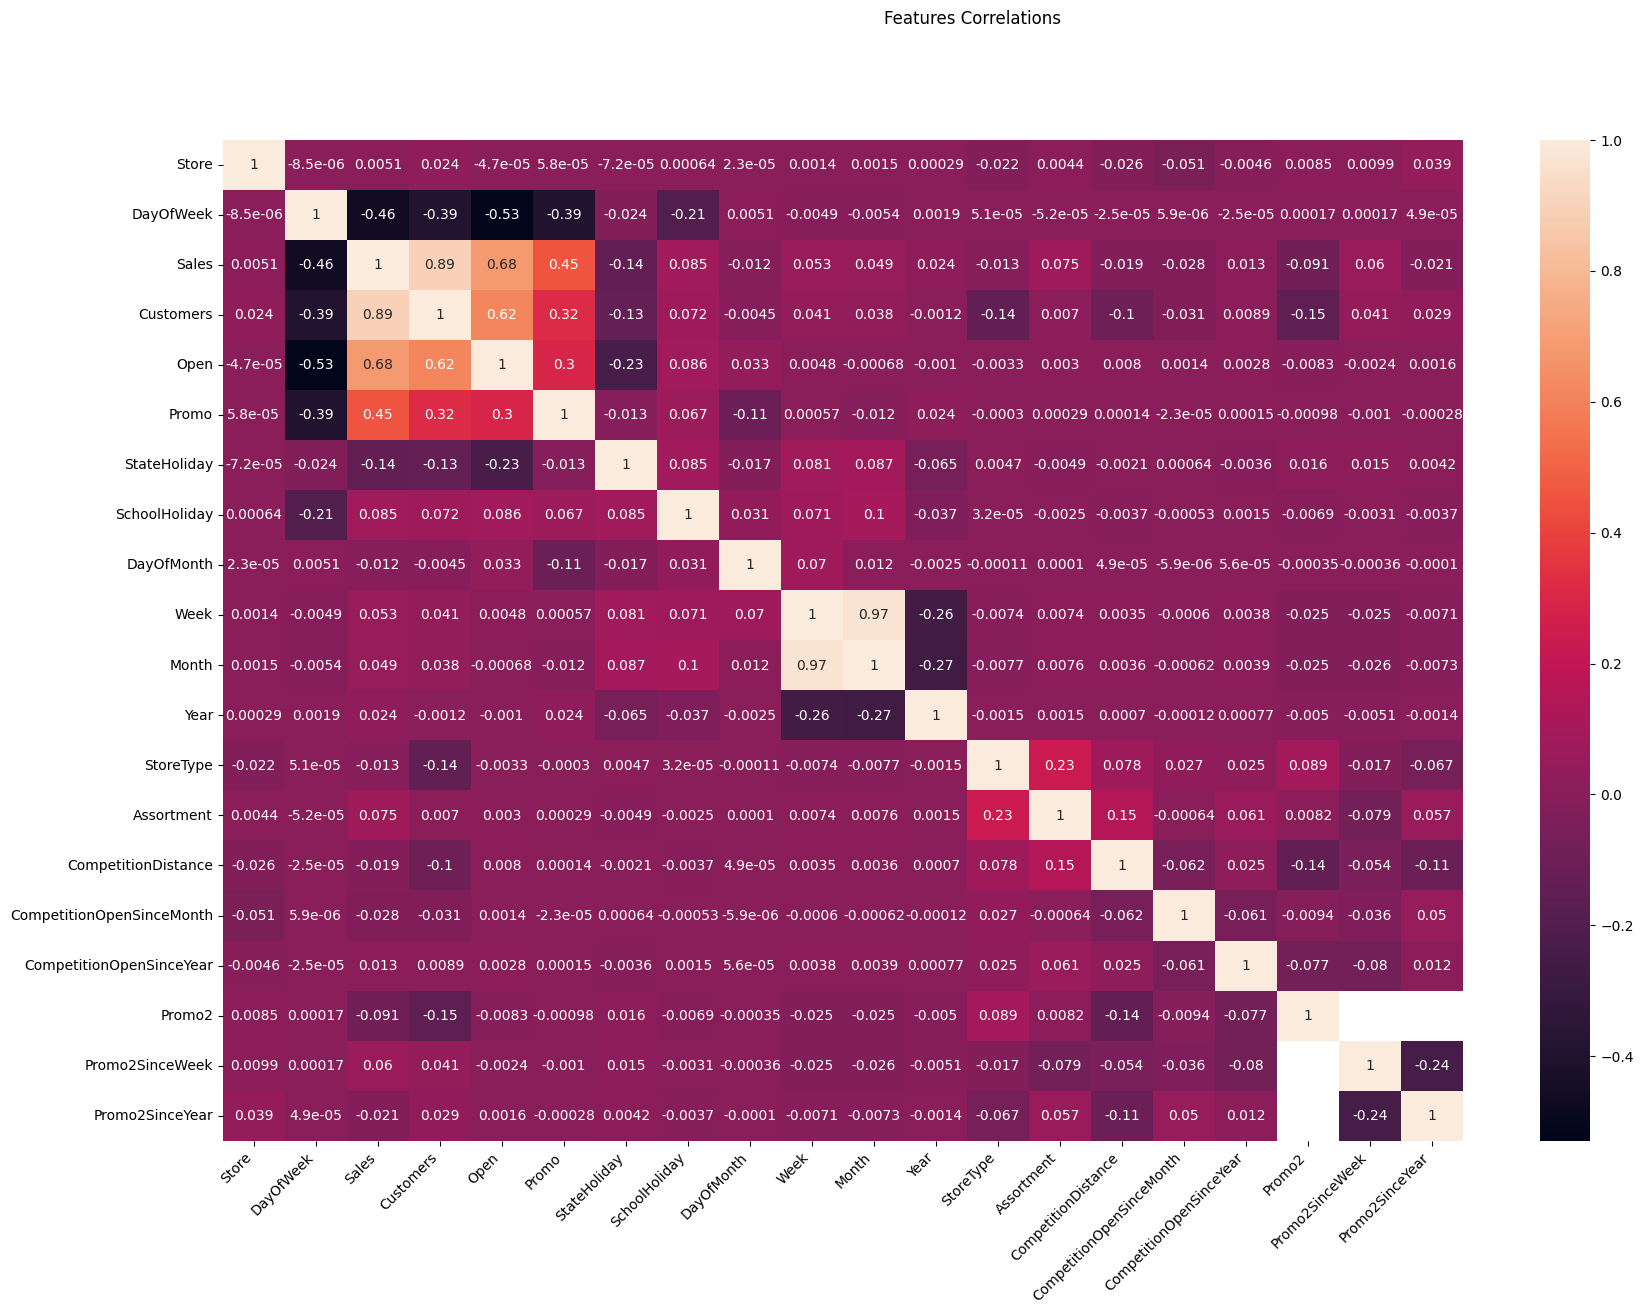

In [23]:
corr = stores_sales_copy.drop("PromoInterval", axis="columns").corr()

fig = plt.figure(figsize=(20, 13))
fig.suptitle("Features Correlations")
sns.heatmap(corr, annot=True)
plt.xticks(rotation=45, ha="right");

- We can confirm that **Sales** and **Customers** have indeed a high correlation with each other. This makes sense, as the higher the number of customers, then higher the sales will certainly be.
- As mentioned above, **Customers** have almost the correlations with other features as **Sales**.
- **Promo** also affects **Sales** positively. The promotions must be effective in attracting customers.
- The **DayOfWeek** haves a negative impact on **Sales**, as sales in week day represented by 6 (Mondays) the stores have high probability of being closed.
- A similiar (and logical) reasoning can be applyed to explaing the positive impatict of **Open** to **Sales**.
- A similar reasoning can explain the negative impacto of **DayOfWeek** in **Customers**, **Open** and **Promo**.
- **StoreType** and **Assortment** have some positive correlation, indicating that store type may be specialized in specific assortments.
- Interestingly, **Assortment** has some correlation with **CompetitionDistance**, indicating that, to be competitive, stores may sell products that competitors also sell.

### Customer Behavior

First of all, let's undersdand how the number of customers (**Customers**) relate to sales and other store attributes. Let's also investigate how customers respond to promotions based on store type or assortment.

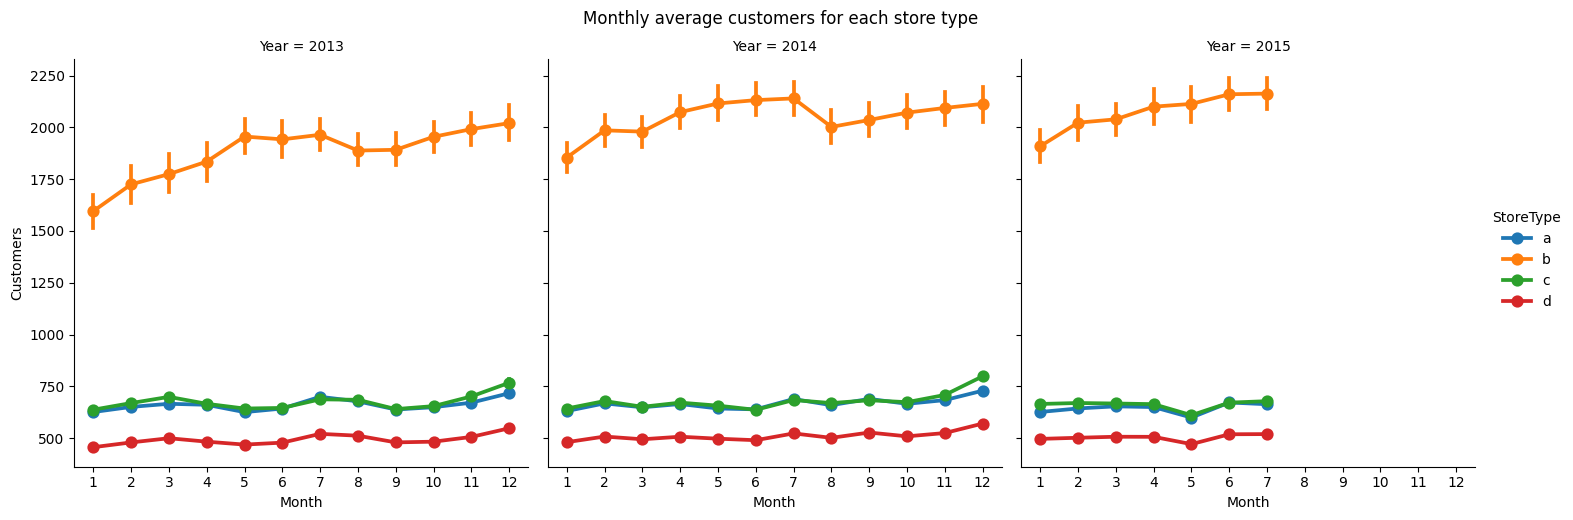

In [47]:
g = sns.catplot(
    data=stores_sales_df,
    x="Month",
    y="Customers",
    kind="point",
    col="Year",
    hue="StoreType",
    hue_order=["a", "b", "c", "d"],
)
g.fig.suptitle("Monthly average customers for each store type", y=1.03);

In terms of monthly customers:
- Stores of type **a**, **c** and **d** exibits the same periodic pattern, with hihg points march, july and, the highest point, in december.
- Stores of type **a** and **c** have almost the same monthly numbers, while stores of type **d** have a similar behavior, but with lower levels.
- Stores of type **b** alone displays some interesting behaviors:
    - monthly number are away higher than other store types.
    - we can see a gradual change in monthly inidicators throughout the years, mainly in period of january to april, where the monthly number of customers is years 2015 and 2014 is signifacntly higher than the same period in 2013.
    - in may and june, there is an increse of number of customers, while we have decrease of customers in other store types for the same period.

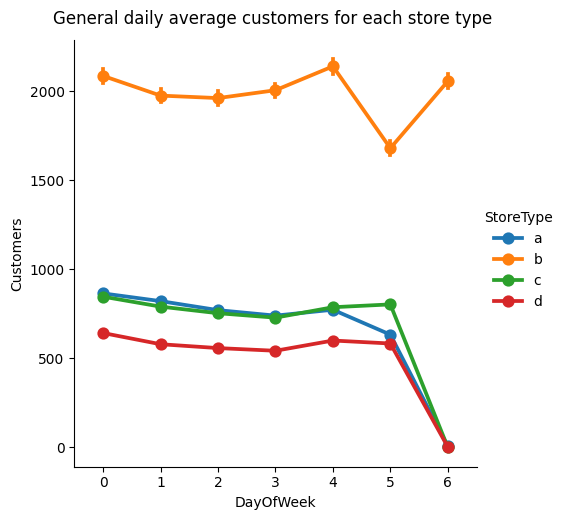

In [49]:
g = sns.catplot(
    data=stores_sales_df,
    x="DayOfWeek",
    y="Customers",
    kind="point",
    hue="StoreType",
    hue_order=["a", "b", "c", "d"],
)
g.fig.suptitle("General daily average customers for each store type", y=1.03);

- Stores **b** outperforms other store types in weekly metrics to.
    - we have a confirmation that this store type don't close at sundays.
    - on saturdays, although the number of customer level is low w.r.t the other week days, it still greatly outperforms  the other store types.

### Store Performance and Characteristics

Now we'll try to understand sales performance correlates with store types and assortment levels.

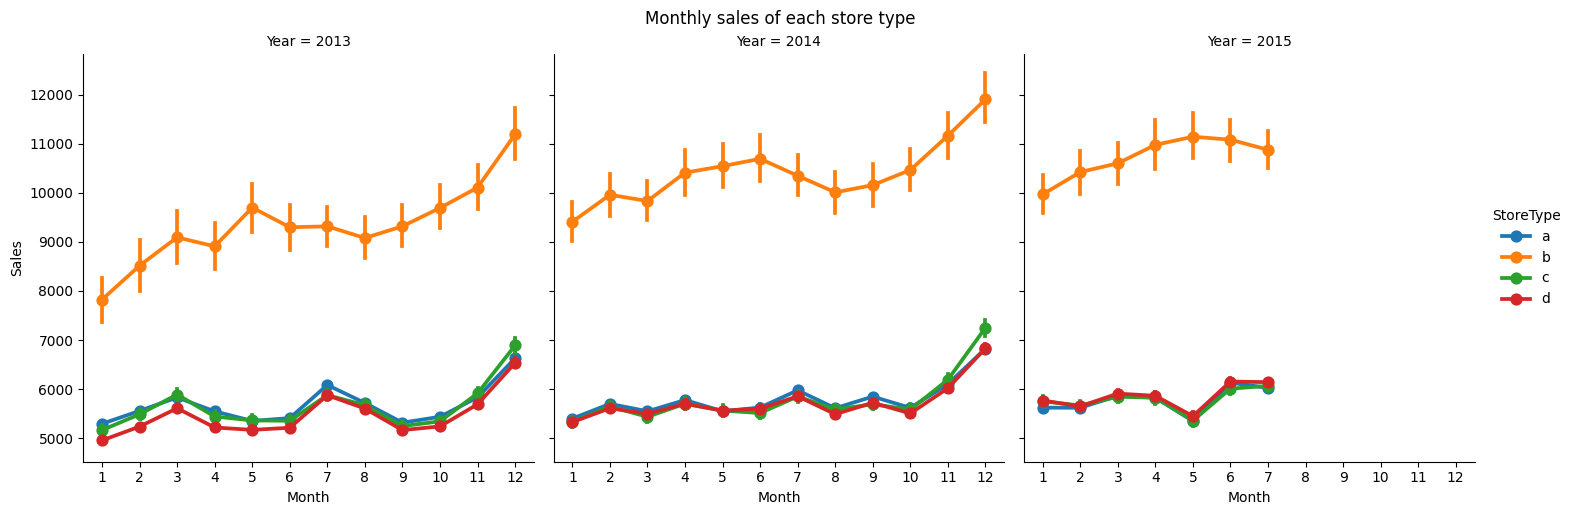

In [45]:
g = sns.catplot(
    data=stores_sales_df,
    x="Month",
    y="Sales",
    kind="point",
    col="Year",
    hue="StoreType",
    hue_order=["a", "b", "c", "d"],
)
g.fig.suptitle("Monthly average sales of each store type", y=1.02);

- These metrics display a similar behavior of customer behavior.
    - for stores **a**, **b** and **c**periodic pattern, with high points march, july and, the highest point, in december.
    - stores of type `b` have the higher monthly sales througout the year.
    - change in monthly inidicators for store **b** throughout the years.
- Besides that, we can see that the period high number of customers inccur in even higher sales levels, indicating that not only the number of customers impact in sales, but the average purchase values for those customers also increase.

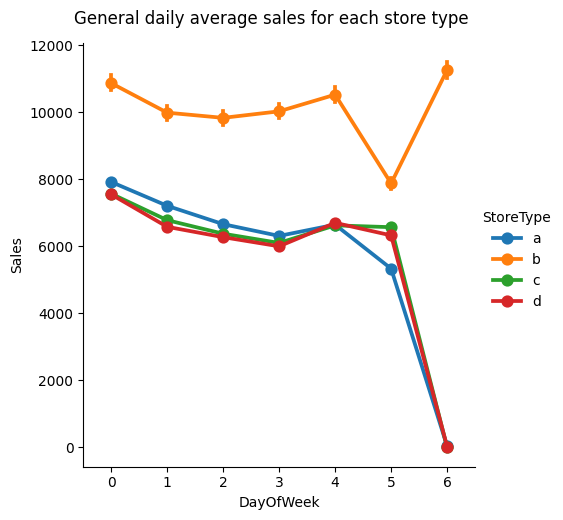

In [50]:
g = sns.catplot(
    data=stores_sales_df,
    x="DayOfWeek",
    y="Sales",
    kind="point",
    hue="StoreType",
    hue_order=["a", "b", "c", "d"],
)
g.fig.suptitle("General daily average sales for each store type", y=1.03);

Sales behavior during the week follow pretty much the same behavior of customers numbers.

### Seasonal and Temporal Patterns

Now, we'll try to identify the seasonal and temporal patterns in sales data by checking how it varies by month, day of the week and year. We'll also investigate how holidays impact sales and if they have any impact among different store types.

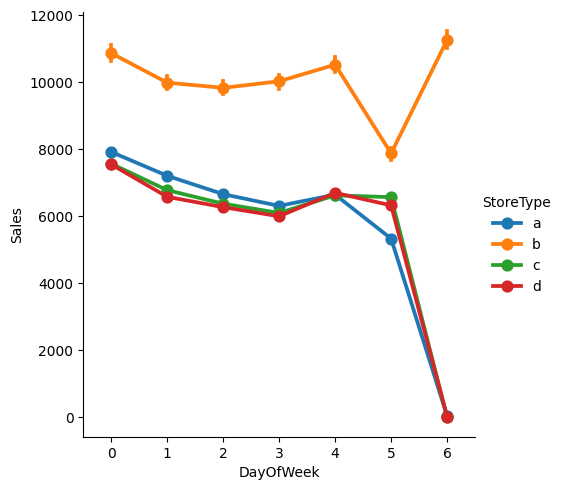

In [46]:
g = sns.catplot(
    data=stores_sales_df,
    x="DayOfWeek",
    y="Sales",
    kind="point",
    hue="StoreType",
    hue_order=["a", "b", "c", "d"]
)

All store types have the same daily behavior, except for stores of type **b** that seems to not close at sundays. This may be the reason why these store types have higher sales performance throughout the year.

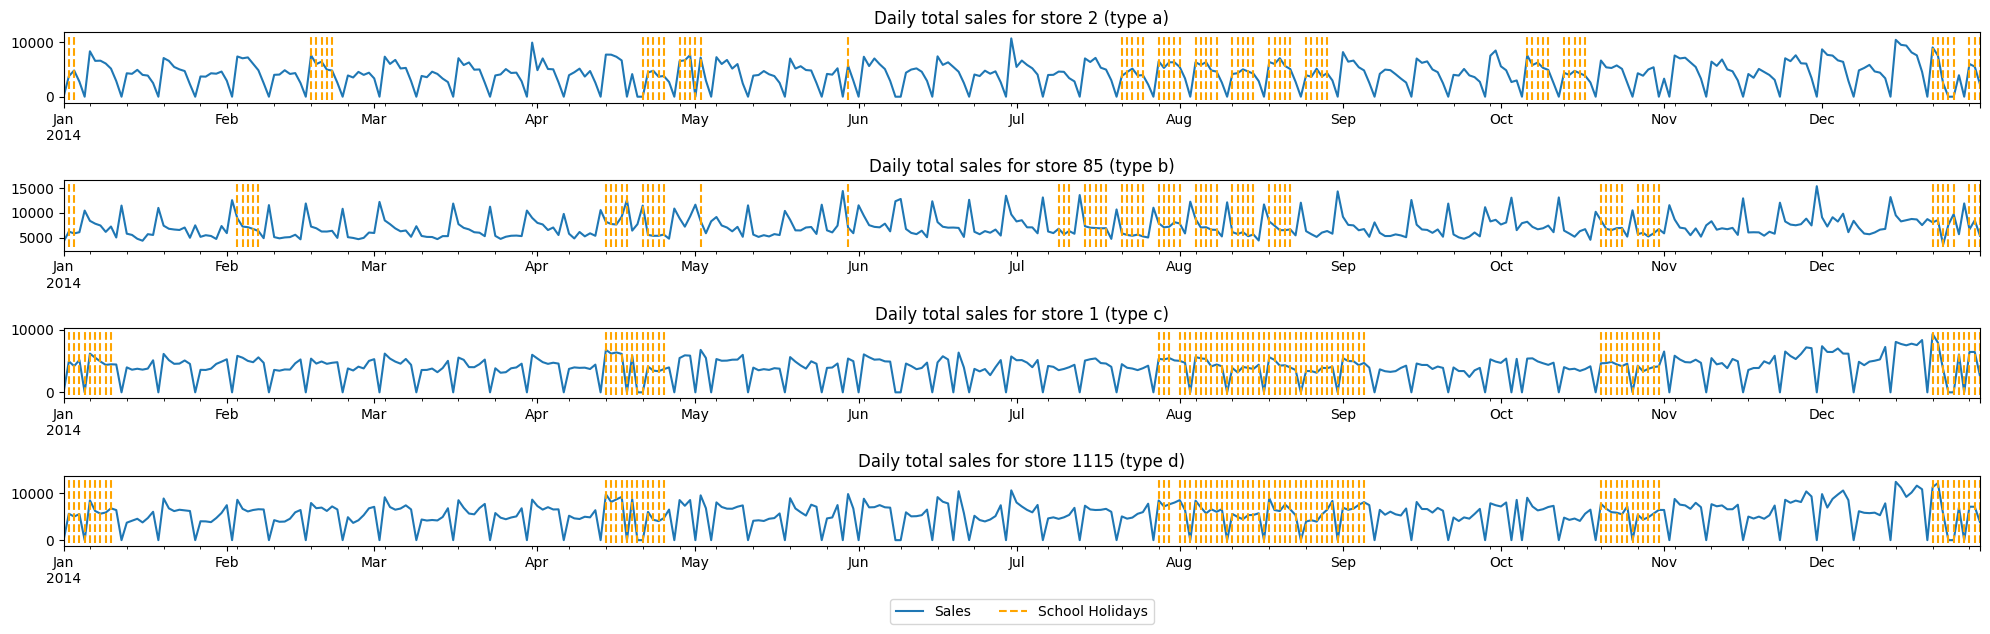

In [27]:
plt.figure(figsize=(20, 7))

for fig_idx, (store_id, store_type) in enumerate([(2, "a"), (85, "b"), (1, "c"), (1115, "d")]):
    store = stores_sales_df[stores_sales_df["Store"] == store_id].loc["2014"]
    holidays = store[store["SchoolHoliday"] != 0]["SchoolHoliday"]
    
    ax= plt.subplot(4, 1, fig_idx+1)
    ax = store["Sales"].plot(kind="line")
    ax.set_title(f"Daily total sales for store {store_id} (type {store_type})")
    ax.set_xlabel("")

    ymin, ymax = ax.get_ylim()
    ax.vlines(holidays.index, ymin=ymin, ymax=ymax, ls="--", colors=["orange"], label="School Holidays")

plt.legend(bbox_to_anchor=(0.5, -1.2), ncols=2, loc='lower center')
plt.tight_layout()
plt.show();

We can see that, as stores aren't closed at school holidays (including winter and summer holidays), sales generally aren't affect by them.

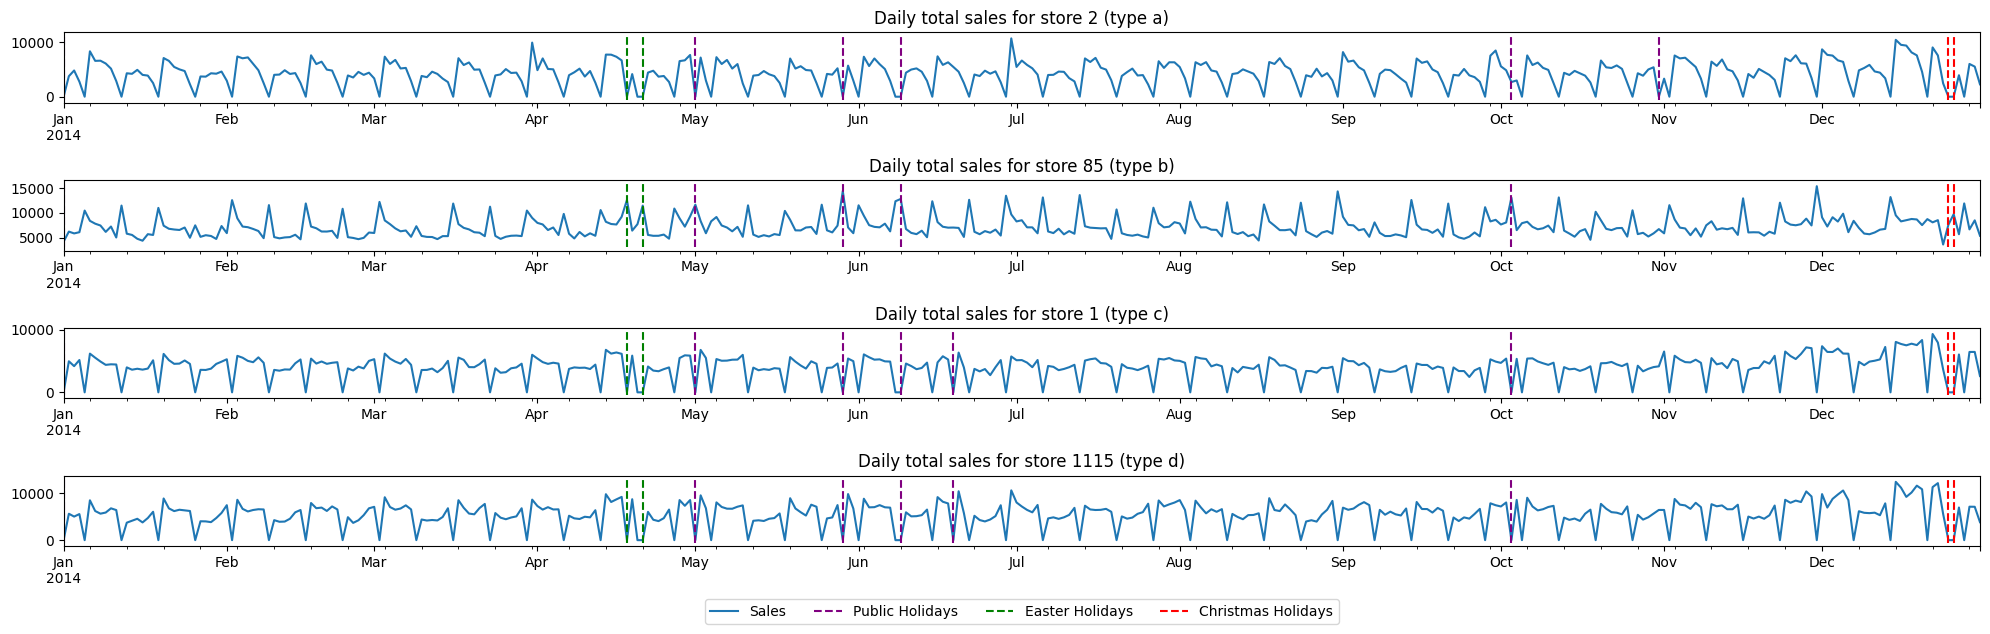

In [28]:
plt.figure(figsize=(20, 7))

for fig_idx, (store_id, store_type) in enumerate([(2, "a"), (85, "b"), (1, "c"), (1115, "d")]):
    store = stores_sales_df[stores_sales_df["Store"] == store_id].loc["2014"]
    
    ax= plt.subplot(4, 1, fig_idx+1)
    ax = store["Sales"].plot(kind="line")
    ax.set_xlabel("")
    ax.set_title(f"Daily total sales for store {store_id} (type {store_type})")

    ymin, ymax = ax.get_ylim()
    
    public_holidays = store[store["StateHoliday"] == "a"]["SchoolHoliday"]
    ax.vlines(public_holidays.index, ymin=ymin, ymax=ymax, ls="--", colors=["purple"], label="Public Holidays")
    
    public_holidays = store[store["StateHoliday"] == "b"]["SchoolHoliday"]
    ax.vlines(public_holidays.index, ymin=ymin, ymax=ymax, ls="--", colors=["green"], label="Easter Holidays")
    
    public_holidays = store[store["StateHoliday"] == "c"]["SchoolHoliday"]
    ax.vlines(public_holidays.index, ymin=ymin, ymax=ymax, ls="--", colors=["red"], label="Christmas Holidays")

plt.legend(bbox_to_anchor=(0.5, -1.2), ncols=4, loc='lower center')
plt.tight_layout()
plt.show();

Again, store of type **b** is an exception. All store types get closed at state holidays, so sales are zero for those days. But for stores of type **b**, sales increase at state holidays.

### Promotion Impact

Let's check the effect of consecutive promotions (Promo2) on sales, how does it differ across store types and assortments, and how do Promo2 intervals (PromoInterval) align with sales increases

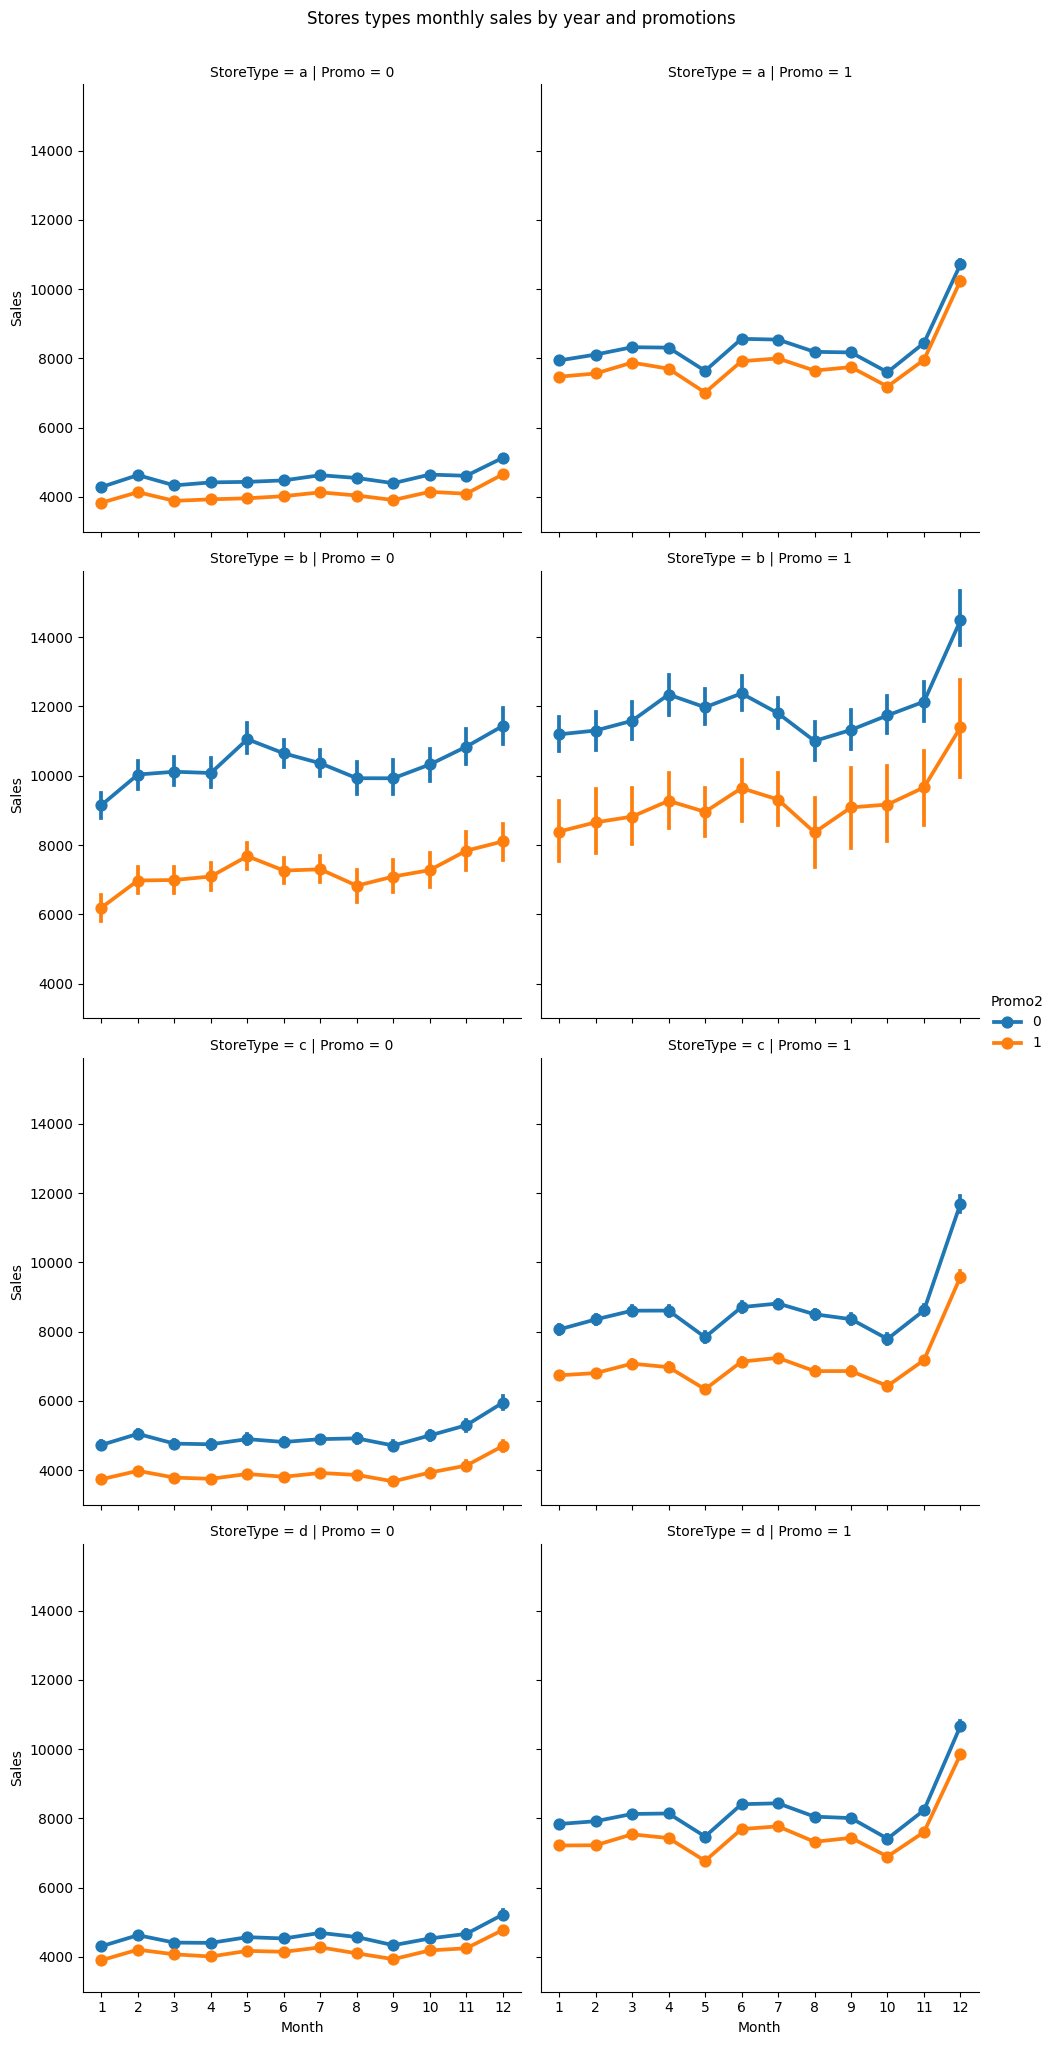

In [29]:
g = sns.catplot(
    data=stores_sales_df,
    x="Month",
    y="Sales",
    kind="point",
    col="Promo",
    hue="Promo2",
    row="StoreType",
    row_order=["a", "b", "c", "d"]
)
g.fig.suptitle("Stores types monthly sales by year and promotions", y=1.02);

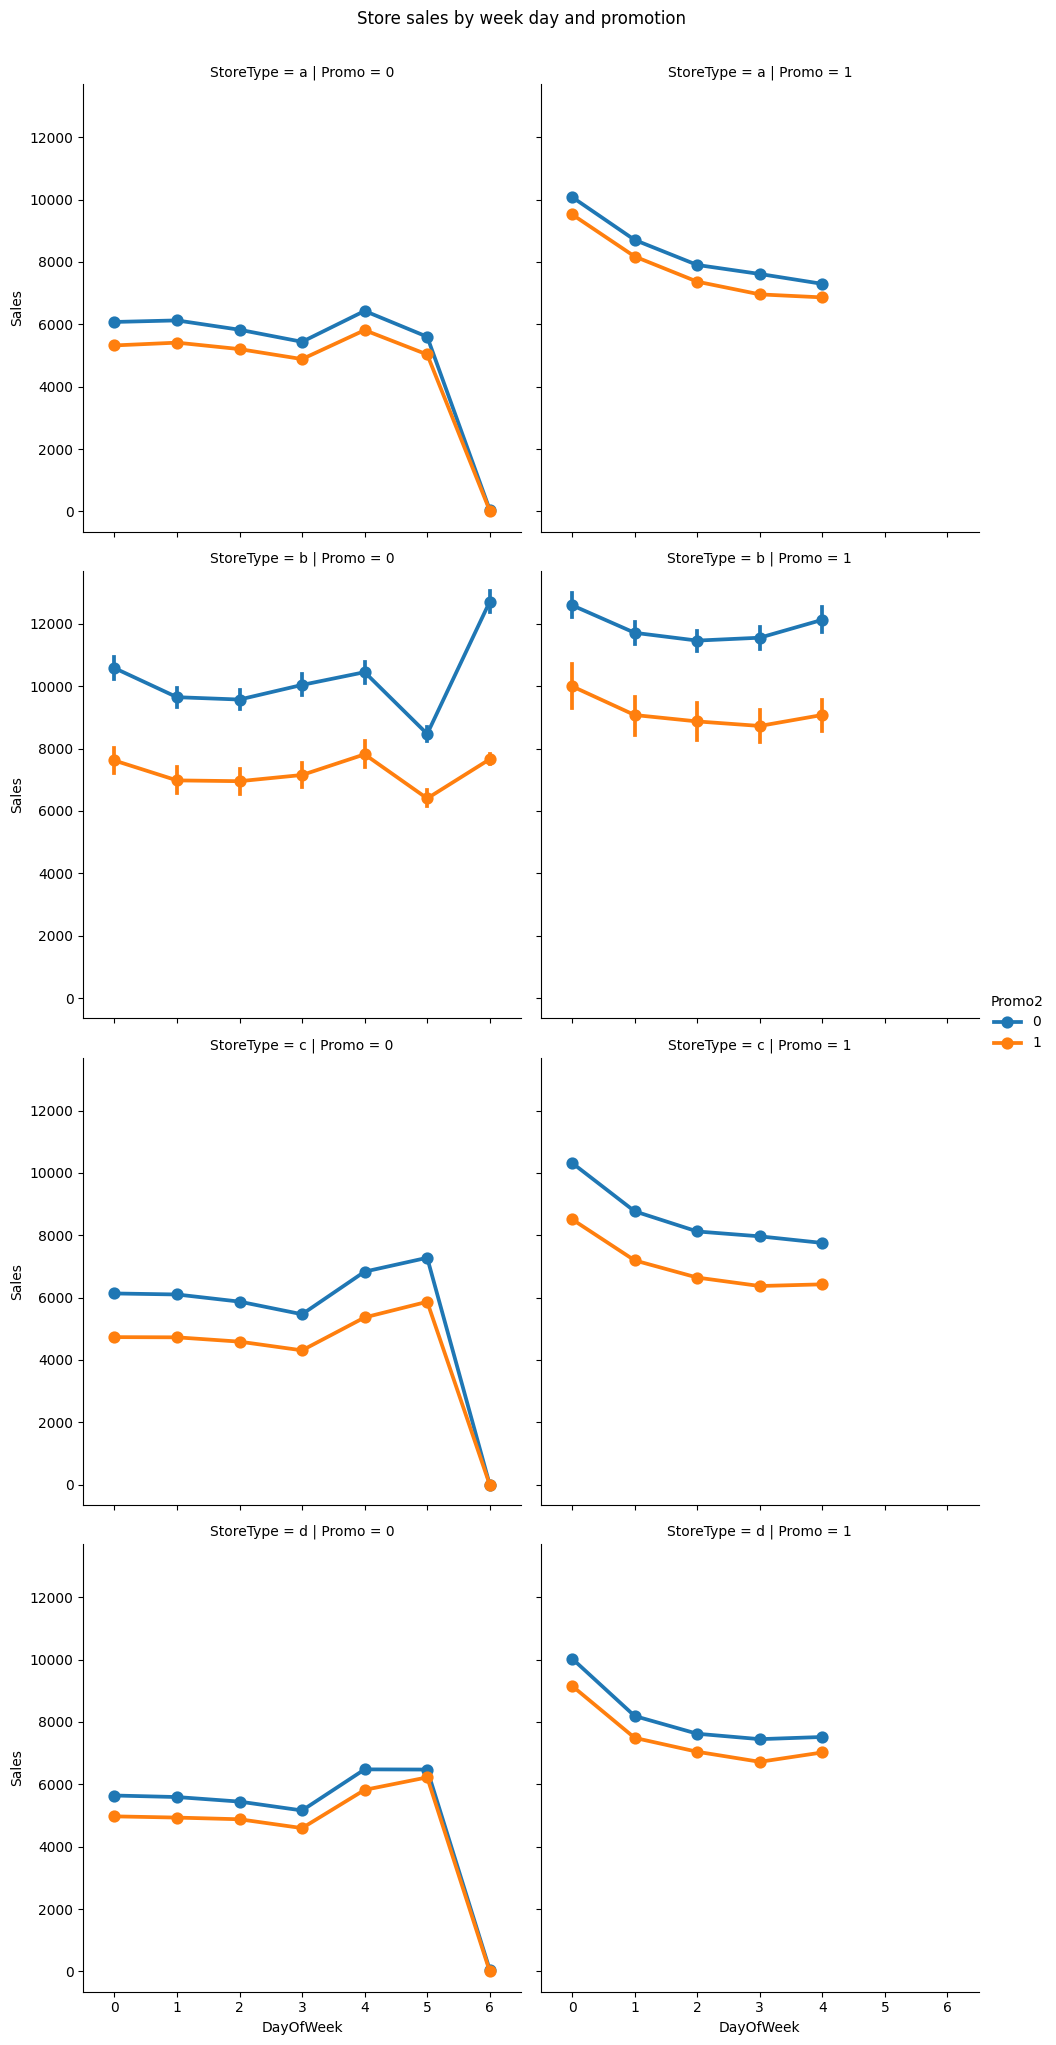

In [33]:
g = sns.catplot(
    data=stores_sales_df,
    kind="point",
    x="DayOfWeek",
    y="Sales",
    col="Promo",
    hue="Promo2",
    row="StoreType",
    row_order=["a", "b", "c", "d"]
)
g.fig.suptitle("Store sales by week day and promotion", y=1.02);

- We can confirm general trends aready discussed
    - higher sales on mondays.
    - higher sales in the end of the year.
    - stores of type **b** don't close in weekends and sundays are very profitable.
- There aren't promotions on saturdays and sundays.
- Promotions are most effective on mondays.
- **Promo1** does have an impact on sales, as we can see that the average sales with promotions are higher.
- **Promo2** doesn't have impact on sales.

### General Insights
-  Given the low occurences in the dataset and few days closed, stores of type `b` may be some kind of suppliers for the others.

# Feature Engineering

Creating additional relevant features from the existing data, such as lagged sales, rolling statistics, or any other variables that might impact sales.

### Collect sample store

In [36]:
sample_store = (
    joined_sales_stores_df[joined_sales_stores_df["Store"] == 2]
        .drop(["StoreType", "DayName"], axis="columns")
)
sample_store

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Month,Year,Promo2
Date,,,,,,,,,,,
2013-01-01,2,1,0,0,0,0,a,1,1,2013,1
2013-01-02,2,2,4422,650,1,0,0,1,1,2013,1
2013-01-03,2,3,4159,555,1,0,0,1,1,2013,1
2013-01-04,2,4,4484,574,1,0,0,1,1,2013,1
2013-01-05,2,5,2342,324,1,0,0,0,1,2013,1
...,...,...,...,...,...,...,...,...,...,...,...
2015-07-27,2,0,6627,638,1,1,0,1,7,2015,1
2015-07-28,2,1,5671,646,1,1,0,1,7,2015,1
2015-07-29,2,2,6402,727,1,1,0,1,7,2015,1


### Check for Stationarity

In [37]:
def test_stationarity(series: pd.DataFrame, confidence: float = 0.05) -> None:
    roll_mean = series.rolling(window=7).mean()
    roll_std = series.rolling(window=7).std()
    
    fig, ax = plt.subplots(figsize=(30, 3))
    fig.suptitle("Time series rolling statistics")
    
    ax.plot(series.resample("W").mean(), color="blue", label="original")
    ax.plot(roll_mean.resample("W").mean(), color="red", label="Rolling Mean")
    ax.plot(roll_std.resample("W").mean(), color="green", label="Rolling STD")
    ax.legend(loc="best")
    plt.show()
    
    adfuller_results = adfuller(series, autolag="AIC")
    records1 = {
        k: v for k, v in zip(
            ("Test Statistic", "p-value", "# Lags Used"),
            adfuller_results[:3]
        )
    }
    for key, value in adfuller_results[4].items():
        records1[f"Critical Value ({key})"] = value
    
    kpss_results = kpss(series, nlags="auto")
    records2 = {
        k: v for k, v in zip(
            ("Test Statistic", "p-value", "# Lags Used"),
            kpss_results[:3]
        )
    }
    for key, value in kpss_results[3].items():
        records2[f"Critical Value ({key})"] = value
    
    results_df = pd.DataFrame.from_records((records1, records2), index=[
        "ADF", "KPSS"
    ])
    display(results_df.T)
    
    adf_stationarity = records1["p-value"] < confidence
    kpss_stationarity = records2["p-value"] > confidence
    
    print(f"ADF stationarity: {adf_stationarity} -- KPSS stationarity: {kpss_stationarity}")

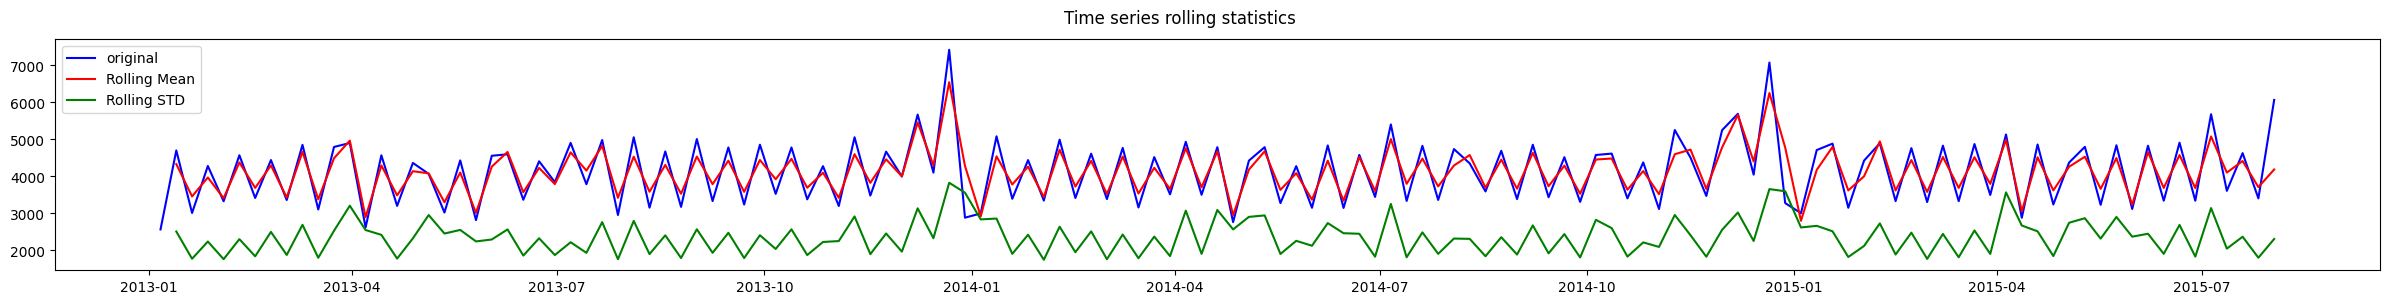

,ADF,KPSS
Test Statistic,-6.369024e+00,0.300305
p-value,2.370295e-08,0.100000
# Lags Used,2.100000e+01,53.000000
Critical Value (1%),-3.437478e+00,0.739000
Critical Value (5%),-2.864687e+00,0.463000
Critical Value (10%),-2.568445e+00,0.347000
Critical Value (2.5%),NaN,0.574000


ADF stationarity: True -- KPSS stationarity: True


In [38]:
test_stationarity(sample_store["Sales"])

### Check for trend and seasonality

In [39]:
def plot_timeseries(series: pd.DataFrame):
    fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, sharex=True, sharey=False, figsize=(30, 7))
    
    decomposition = seasonal_decompose(series, model="additive", period=365)
    
    estimated_trend = decomposition.trend
    estimated_seasonal = decomposition.seasonal
    estimated_residual = decomposition.resid
    
    ax1.plot(estimated_trend, color="blue")
    ax1.set_title("Trend")
    
    ax2.plot(estimated_seasonal, color="red")
    ax2.set_title("Seasonal")
    
    ax3.plot(estimated_residual, color="green")
    ax3.set_title("Residual")
    
    fig.suptitle("Decomposition Plots", y=1.01)
    
    plt.tight_layout()
    plt.show()

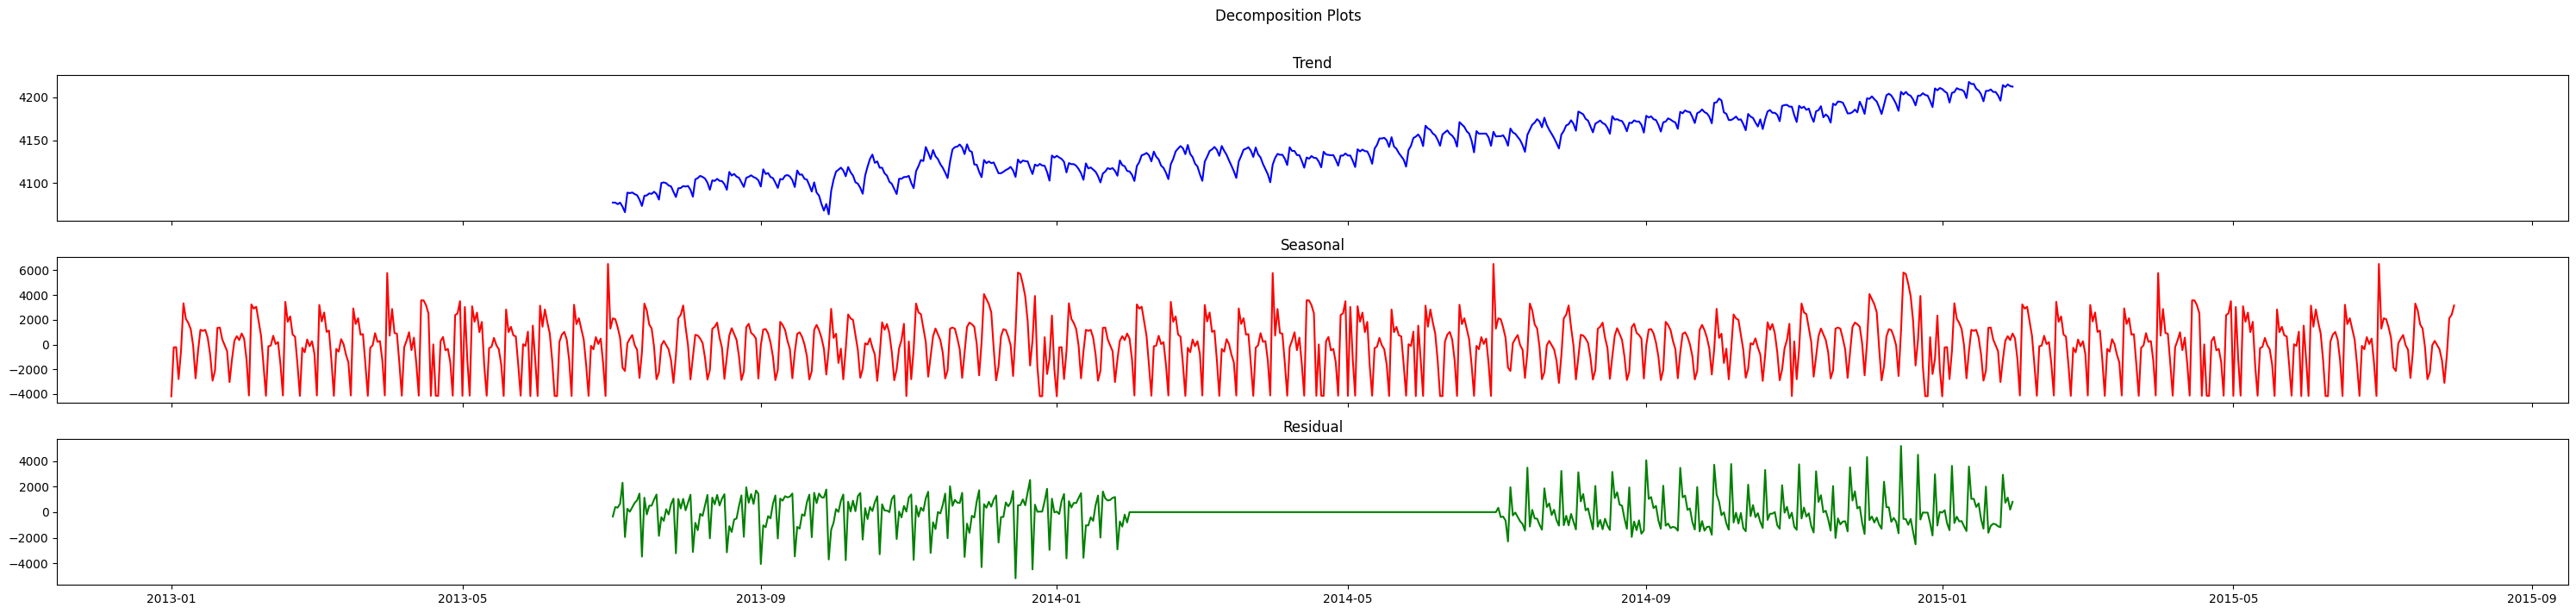

In [40]:
plot_timeseries(sample_store["Sales"])

# Model Selection

Choosing an appropriate machine learning model for time series forecasting. Common models for time series forecasting include ARIMA, Prophet, and various machine learning algorithms such as Random Forest, XGBoost, or LSTM (Long Short-Term Memory).

<Axes: xlabel='Date'>

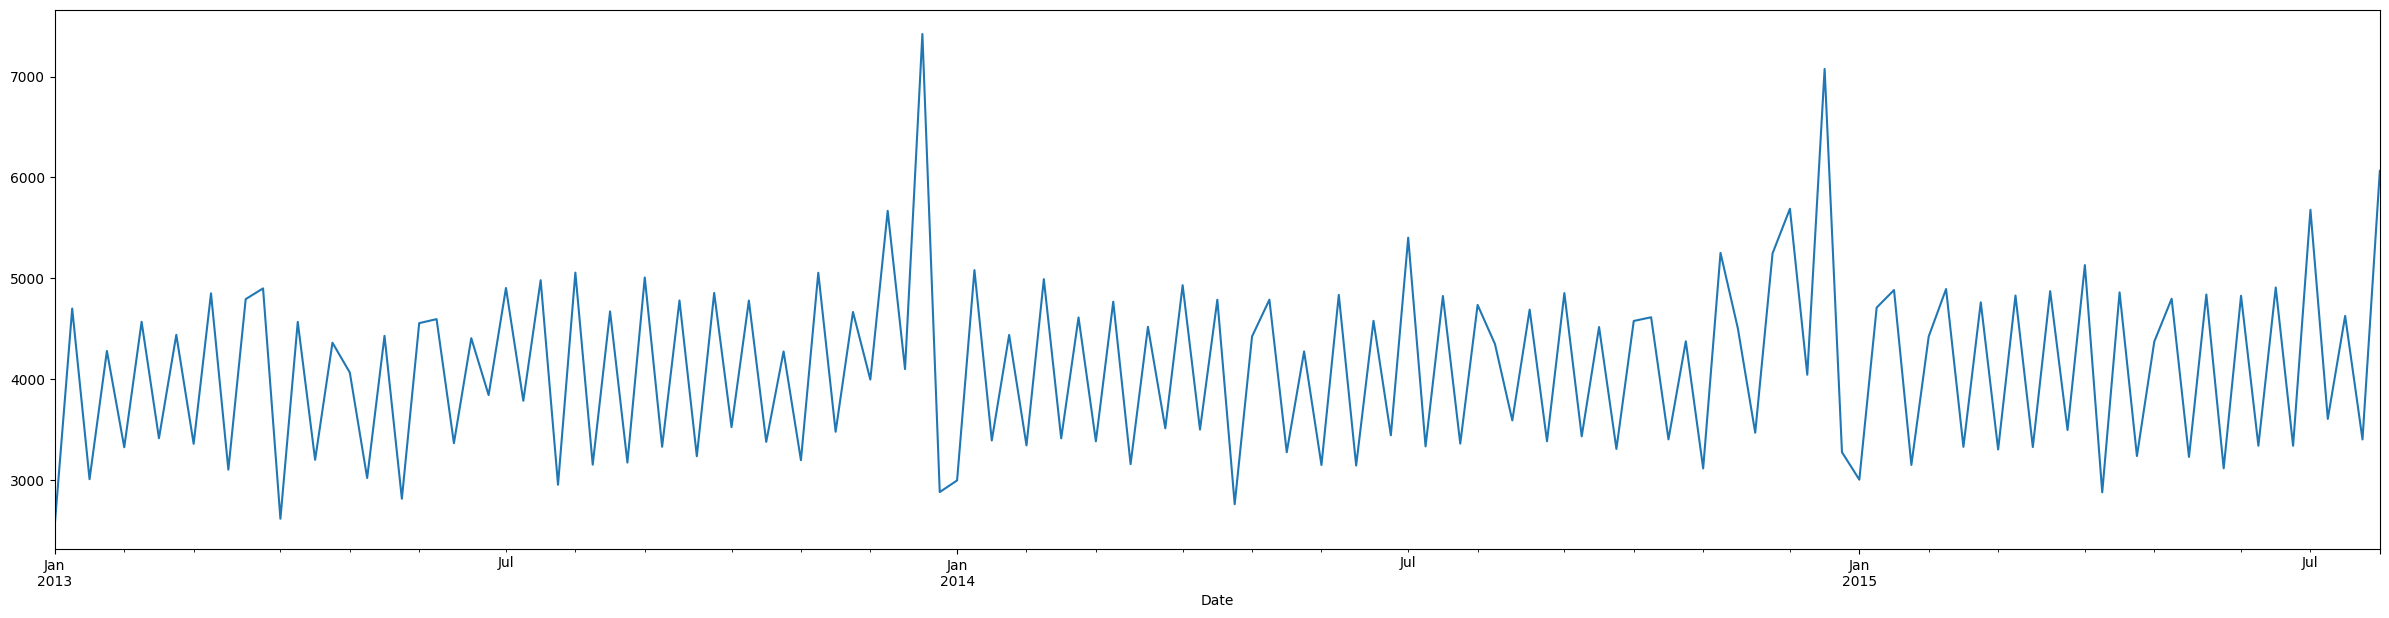

In [41]:
sarimax_dataset = sample_store["Sales"].resample("W").mean()

sarimax_dataset.plot(kind="line", figsize=(30, 7))

In [42]:
data_len = len(sarimax_dataset.index)
test_len = int(data_len * 0.2)

train_df = sarimax_dataset.iloc[:-test_len+1]
test_df = sarimax_dataset.iloc[-test_len:]

display(train_df)
display(test_df)

Date
2013-01-06    2567.833333
2013-01-13    4702.000000
2013-01-20    3011.571429
2013-01-27    4281.857143
2013-02-03    3328.142857
                 ...     
2015-01-04    3007.142857
2015-01-11    4711.571429
2015-01-18    4885.142857
2015-01-25    3152.857143
2015-02-01    4426.000000
Freq: W-SUN, Name: Sales, Length: 109, dtype: float64

Date
2015-02-01    4426.000000
2015-02-08    4895.285714
2015-02-15    3332.142857
2015-02-22    4763.285714
2015-03-01    3306.142857
2015-03-08    4830.714286
2015-03-15    3329.857143
2015-03-22    4874.000000
2015-03-29    3498.857143
2015-04-05    5132.428571
2015-04-12    2881.571429
2015-04-19    4861.857143
2015-04-26    3241.285714
2015-05-03    4374.571429
2015-05-10    4798.857143
2015-05-17    3232.285714
2015-05-24    4841.285714
2015-05-31    3119.714286
2015-06-07    4828.428571
2015-06-14    3343.285714
2015-06-21    4910.428571
2015-06-28    3343.000000
2015-07-05    5679.571429
2015-07-12    3609.142857
2015-07-19    4628.428571
2015-07-26    3405.428571
2015-08-02    6066.200000
Freq: W-SUN, Name: Sales, dtype: float64

## SARIMA

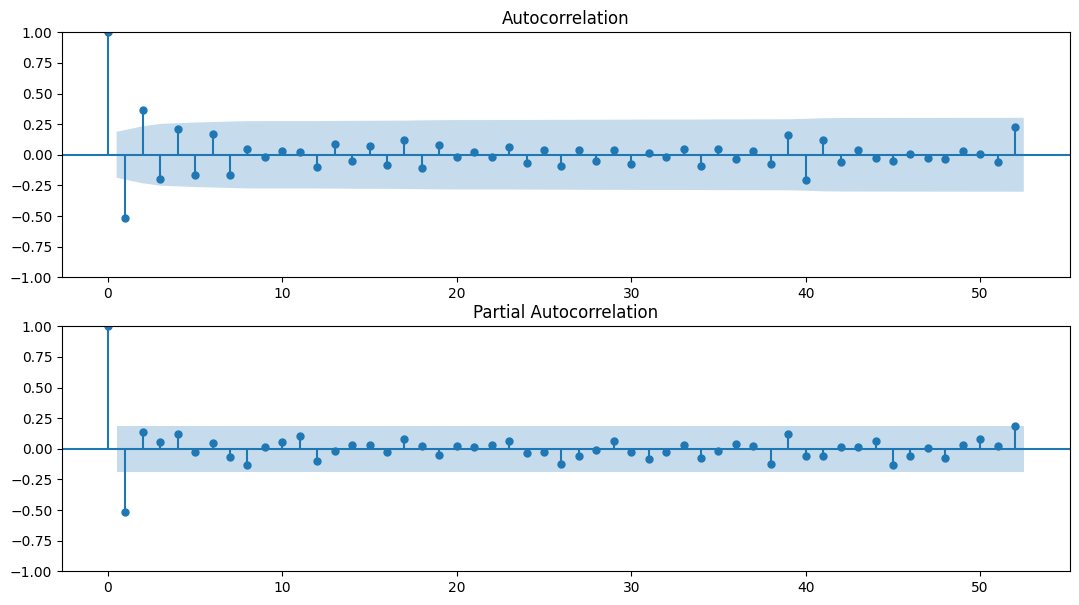

In [43]:
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(13, 7))

sm.graphics.tsaplots.plot_acf(train_df, lags=52, ax=ax1)
sm.graphics.tsaplots.plot_pacf(train_df, lags=52, ax=ax2)

plt.show()

# Model Training

Using historical data to train the selected model. We will use a portion of the data for training and hold out another portion for evaluation.

In [44]:
auto_arima_results = auto_arima(
    train_df,
    start_p=0,
    start_q=0,
    d=0,
    max_p=2,
    max_q=2,
    max_d=2,
    start_P=1,
    start_Q=1,
    D=0,
    max_P=2,
    max_Q=2,
    max_D=1,
    max_order=5,
    m=52,
    seasonal=True,
    trace=True,
    error_action="ignore",
    suppress_warnings=True,
    stepwise=True
)

auto_arima_results.summary()

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,0,1)[52] intercept   : AIC=inf, Time=1.19 sec
 ARIMA(0,0,0)(0,0,0)[52] intercept   : AIC=1793.020, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[52] intercept   : AIC=1758.464, Time=0.71 sec
 ARIMA(0,0,1)(0,0,1)[52] intercept   : AIC=inf, Time=2.08 sec
 ARIMA(0,0,0)(0,0,0)[52]             : AIC=2130.221, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[52] intercept   : AIC=1760.108, Time=0.02 sec
 ARIMA(1,0,0)(2,0,0)[52] intercept   : AIC=inf, Time=13.59 sec
 ARIMA(1,0,0)(1,0,1)[52] intercept   : AIC=inf, Time=2.30 sec
 ARIMA(1,0,0)(0,0,1)[52] intercept   : AIC=inf, Time=1.64 sec
 ARIMA(1,0,0)(2,0,1)[52] intercept   : AIC=inf, Time=12.57 sec
 ARIMA(0,0,0)(1,0,0)[52] intercept   : AIC=1794.768, Time=0.25 sec
 ARIMA(2,0,0)(1,0,0)[52] intercept   : AIC=1752.318, Time=1.50 sec
 ARIMA(2,0,0)(0,0,0)[52] intercept   : AIC=1760.044, Time=0.03 sec
 ARIMA(2,0,0)(2,0,0)[52] intercept   : AIC=inf, Time=12.16 sec
 ARIMA(2,0,0)(1,0,1)[52] intercept   : AIC=inf, Tim

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  109
Model:             SARIMAX(2, 0, 0)x(0, 0, [1], 52)   Log Likelihood                -867.605
Date:                              Tue, 10 Oct 2023   AIC                           1745.210
Time:                                      22:46:22   BIC                           1758.667
Sample:                                  01-06-2013   HQIC                          1750.667
                                       - 02-01-2015                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   5413.5535   1138.425      4.755      0.000    3182.282    7644.826
ar.L1         -0.4744      0.182     -2.602      0.009      -0.832      -0.117
ar.L2          0.1558      0.102      1.526      0.127      -0.044       0.356
ma.S.L52       0.4781      0.190      2.518      0.012       0.106       0.850
sigma2      5.523e+05   1.04e+05      5.304      0.000    3.48e+05    7.56e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.47   Jarque-Bera (JB):                72.55
Prob(Q):                              0.49   Prob(JB):                         0.00
Heteroskedasticity (H):               1.46   Skew:                             1.08
Prob(H) (two-sided):                  0.26   Kurtosis:                         6.36
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

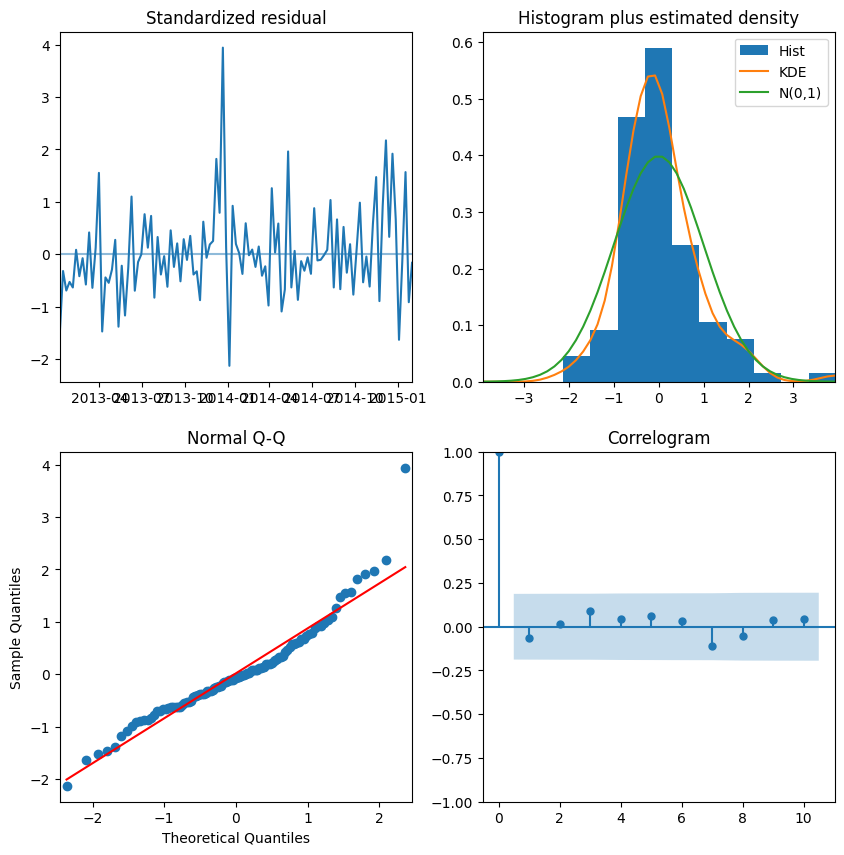

In [45]:
auto_arima_results = auto_arima_results.fit(train_df)

auto_arima_results.plot_diagnostics(figsize=(10, 10))
plt.show()

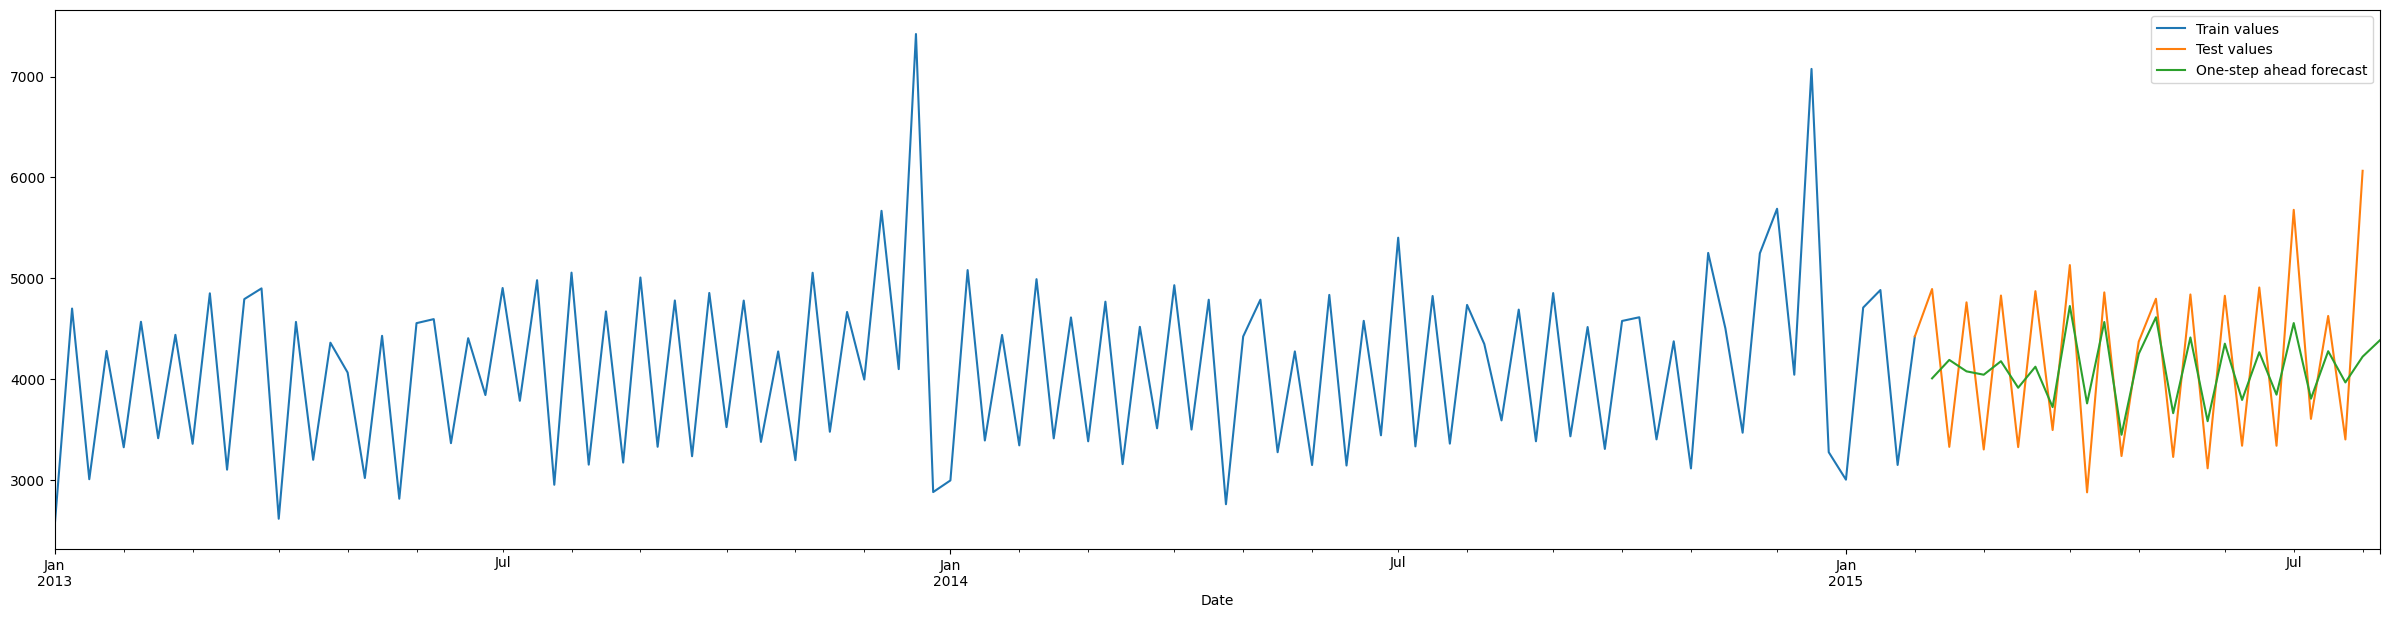

In [46]:
train_preds = auto_arima_results.predict(n_periods=len(test_df))

ax = train_df.plot(label="Train values", kind="line", figsize=(30, 7))
test_df.plot(label="Test values", kind="line", ax=ax)
train_preds.plot(label="One-step ahead forecast", kind="line", ax=ax)

plt.legend();

In [47]:
sarima_model = SARIMAX(
    train_df,
    **auto_arima_results.get_params()
)

sarima_results = sarima_model.fit(disp=False)

sarima_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                Sales   No. Observations:                  109
Model:             SARIMAX(2, 0, 0)x(0, 0, [1], 52)   Log Likelihood                -892.634
Date:                              Tue, 10 Oct 2023   AIC                           1793.268
Time:                                      22:46:25   BIC                           1804.033
Sample:                                  01-06-2013   HQIC                          1797.633
                                       - 02-01-2015                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1633      0.044      3.676      0.000       0.076       0.250
ar.L2          0.8095      0.044     18.412      0.000       0.723       0.896
ma.S.L52       0.9805      0.120      8.158      0.000       0.745       1.216
sigma2      4.355e+05   2.79e-07   1.56e+12      0.000    4.35e+05    4.35e+05
===================================================================================
Ljung-Box (L1) (Q):                  14.02   Jarque-Bera (JB):                11.21
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.57   Skew:                            -0.20
Prob(H) (two-sided):                  0.18   Kurtosis:                         4.52
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 6.27e+27. Standard errors may be unstable.
"""

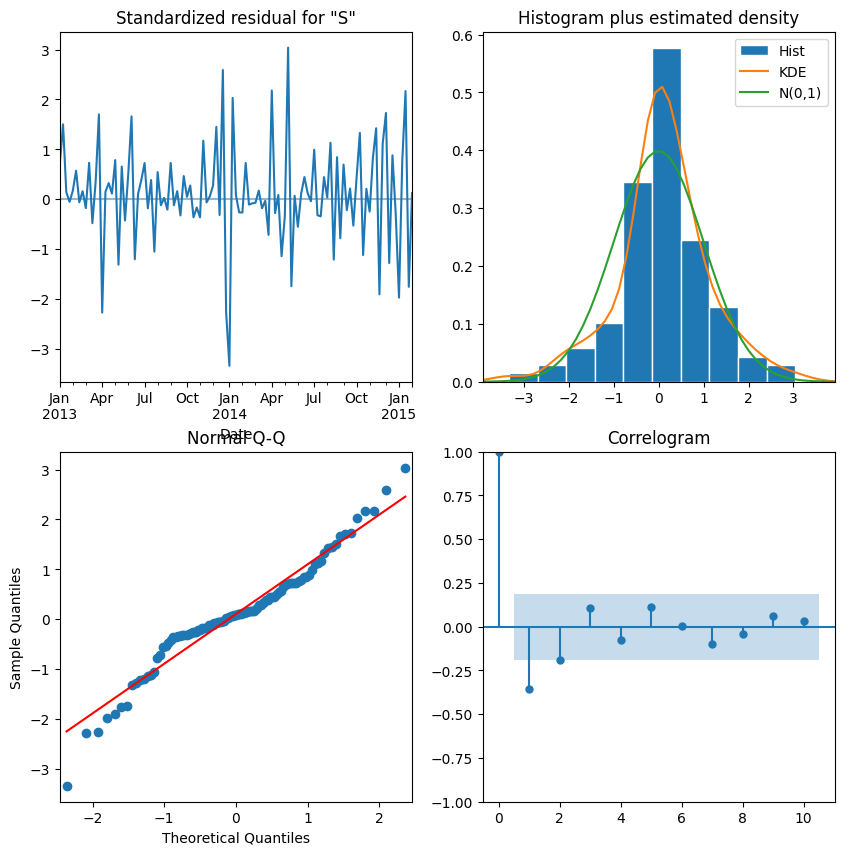

In [48]:
sarima_results.plot_diagnostics(figsize=(10, 10))
plt.show()

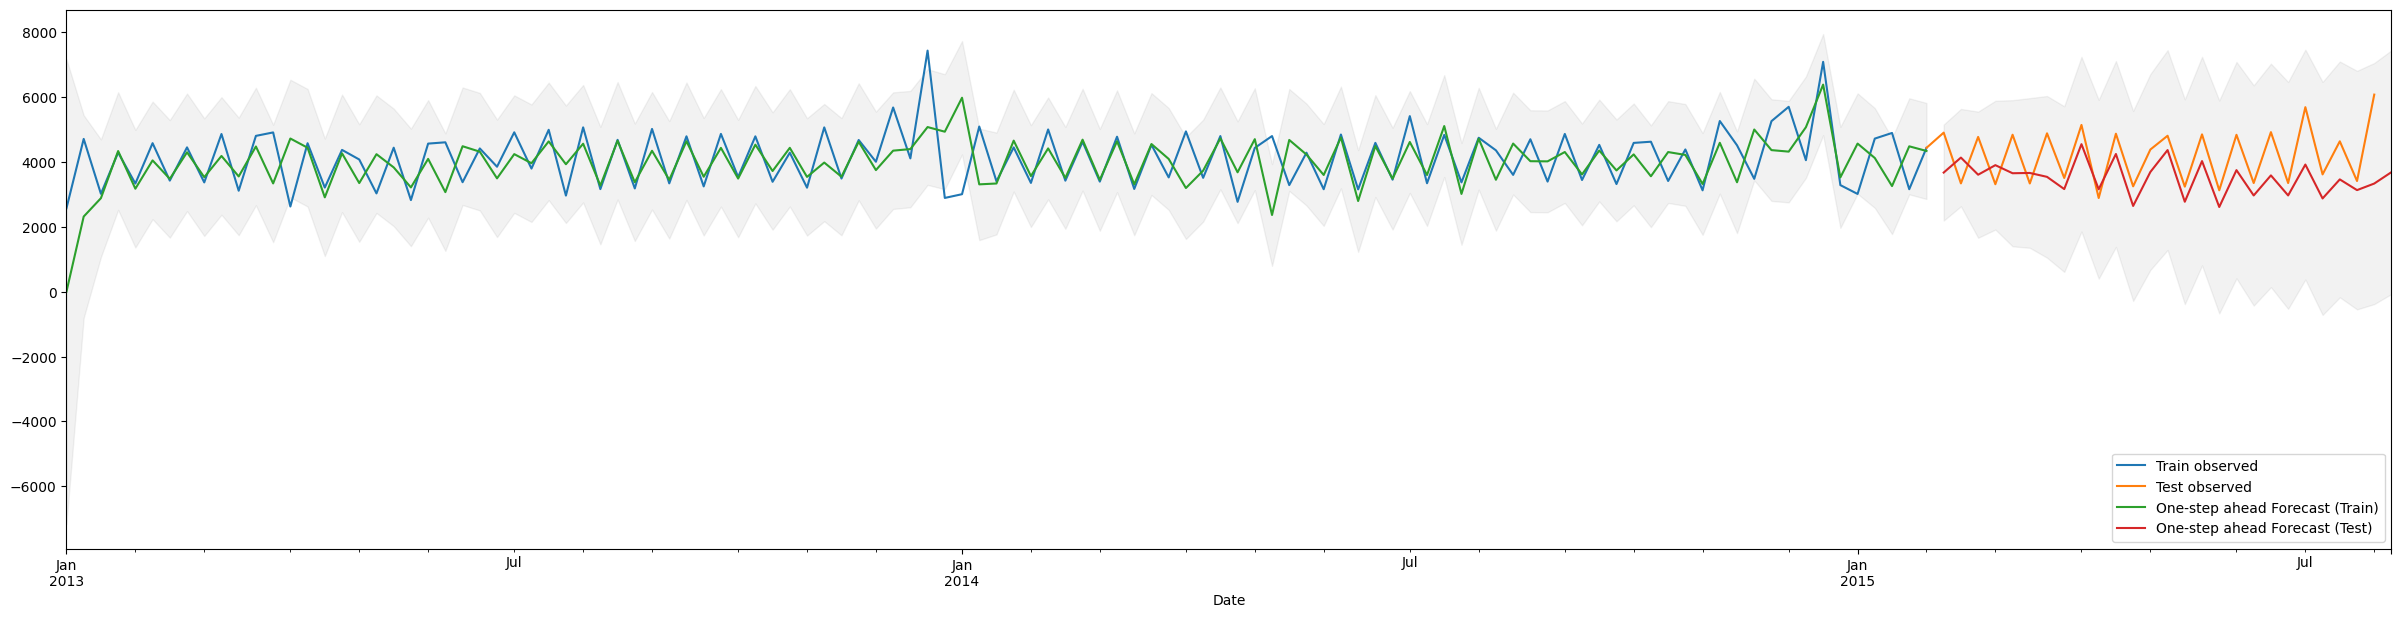

In [49]:
train_preds = sarima_results.get_prediction(dynamic=False)
train_preds_ci = train_preds.conf_int()

test_preds = sarima_results.get_forecast(steps=len(test_df), dynamic=False)
test_preds_ci = test_preds.conf_int()

ax = train_df.plot(label = "Train observed", figsize=(30, 7))
test_df.plot(label="Test observed")

train_preds.predicted_mean.plot(ax=ax, label="One-step ahead Forecast (Train)", alpha=1)
test_preds.predicted_mean.plot(label="One-step ahead Forecast (Test)", ax=ax)

ax.fill_between(
    train_preds_ci.index,
    train_preds_ci.iloc[:, 0],
    train_preds_ci.iloc[:, 1],
    color="k",
    alpha=0.05
)

ax.fill_between(
    test_preds_ci.index,
    test_preds_ci.iloc[:, 0],
    test_preds_ci.iloc[:, 1],
    color="k",
    alpha=0.05
)

plt.legend(loc="lower right");

In [50]:
test_preds.predicted_mean

2015-02-08    3665.454826
2015-02-15    4126.540996
2015-02-22    3599.369634
2015-03-01    3893.603544
2015-03-08    3644.960064
2015-03-15    3653.425792
2015-03-22    3533.474746
2015-03-29    3156.689187
2015-04-05    4539.876433
2015-04-12    3150.869993
2015-04-19    4237.732246
2015-04-26    2637.403266
2015-05-03    3683.542332
2015-05-10    4358.176641
2015-05-17    2767.261373
2015-05-24    4019.040983
2015-05-31    2605.285871
2015-06-07    3740.504750
2015-06-14    2960.043711
2015-06-21    3578.531606
2015-06-28    2961.625583
2015-07-05    3912.189812
2015-07-12    2868.362955
2015-07-19    3455.060196
2015-07-26    3125.128659
2015-08-02    3327.465118
2015-08-09    3678.910239
Freq: W-SUN, Name: predicted_mean, dtype: float64

# Model Evaluation

Assessing the model's performance using evaluation metrics like Mean Absolute Error (MAE), Mean Squared Error (MSE), or Root Mean Squared Error (RMSE).

# Hyperparameter Tuning

Fine-tuning the model's hyperparameters to improve its performance.

# Forecasting

Using the trained model to make sales forecasts for future weeks, considering promotion indicators.

# Visualization and Interpolation

Visualizing the forecasted sales and interpreting the results. This may include identifying the impact of promotions on sales.

# Deployment

If necessary, deploying the model in a production environment for ongoing sales forecasting.